In [19]:
import kagglehub
import os
import shutil

import sys
from pathlib import Path

local_dataset_name = "ieee-fraud-detection"

base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
print(f"Target dataset base path: {dataset_specific_base_path}")
os.makedirs(raw_data_target_dir, exist_ok=True)

# Check if dataset already exists in destination
destination_path = f"/home/jovyan/data/{local_dataset_name}"
if os.path.exists(raw_data_target_dir) and os.listdir(dataset_specific_base_path):
    print(f"Raw dataset already exists at {raw_data_target_dir}")
    print("Skipping download...")
else:
    print(f"Dataset not found locally. Downloading {dataset_id}...")
    download_path = kagglehub.dataset_download(dataset_id)
    print(f"Dataset downloaded to temporary path in container: {download_path}")
    print(f"Copying dataset to persistent raw data volume: {raw_data_target_dir}")
    # Ensure the destination directory exists
    os.makedirs(raw_data_target_dir, exist_ok=True)
    for item in os.listdir(download_path):
        s = os.path.join(download_path, item)
        d = os.path.join(raw_data_target_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

    print(f"Dataset '{dataset_id}' successfully copied to {raw_data_target_dir} in shared volume.")
print(f"Raw dataset in persistent volume at: {raw_data_target_dir}")


Target dataset base path: /home/jovyan/data/ieee-fraud-detection
Raw dataset already exists at /home/jovyan/data/ieee-fraud-detection/raw
Skipping download...
Raw dataset in persistent volume at: /home/jovyan/data/ieee-fraud-detection/raw


In [20]:
# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output
import gc
def reload_utils():
    import importlib
    import utils.etl
    import cis_fraud.etl_chain
    import utils.eda
    import utils.eval
    import utils.submission

    importlib.reload(utils.etl)
    importlib.reload(cis_fraud.etl_chain)
    importlib.reload(utils.eda)
    importlib.reload(utils.eval)
    importlib.reload(utils.submission)
    print("🔁 Reloaded cis_fraud.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission")
# raw_data_target_dir = dataset_specific_base_path / "test"
print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

csv_files = [f for f in os.listdir(raw_data_target_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {raw_data_target_dir}")
if len(csv_files) > 1:
    print(f"Warning: Multiple CSV files found. Using the first one: {csv_files[0]}")



# Define the names of the two CSV files
identity_file_name = "train_identity.csv"
transaction_file_name = "train_transaction.csv"

# Directory for saving processed chunks
# It's good practice to save them in a dedicated subdirectory
output_chunk_dir = os.path.join(raw_data_target_dir, "processed_merged_chunks")

# Chunk processing parameters
chunk_size = 50000  # You might need to adjust this further.
                    # Smaller chunks use less memory per step but result in more files.
save_format = "parquet" # "parquet" (recommended) or "csv"
file_format = "parquet"
# --- Construct full file paths ---
identity_file_path = os.path.join(raw_data_target_dir, identity_file_name)
transaction_file_path = os.path.join(raw_data_target_dir, transaction_file_name)

print(f"Loading identity data from: {identity_file_path}")
df_identity = None
if os.path.exists(identity_file_path):
    try:
        df_identity = pd.read_csv(identity_file_path)
        print("Successfully loaded identity data.")
    except Exception as e:
        print(f"Error loading identity data: {e}")
else:
    print(f"Error: Identity file not found at {identity_file_path}")

# --- Process transaction data in chunks, merge, and save each merged chunk ---
if df_identity is not None and os.path.exists(transaction_file_path) and not os.path.exists(output_chunk_dir):
    print(f"\nProcessing transaction data in chunks from: {transaction_file_path}")
    print(f"Merged chunks will be saved in: {output_chunk_dir}")
    os.makedirs(output_chunk_dir, exist_ok=True) # Create if it doesn't exist
    
    transaction_chunk_iter = pd.read_csv(
        transaction_file_path, 
        chunksize=chunk_size,
        # Consider specifying dtypes here if known, to save memory and prevent issues
        # dtype={col: type for col, type in known_dtypes_transaction.items()},
        # low_memory=False, # Using with chunksize, effect is per chunk
    )
    
    print(f"Reading transaction data in chunks of {chunk_size} rows...")
    
    total_rows_processed = 0
    
    for i, transaction_chunk in enumerate(transaction_chunk_iter):
        current_chunk_number = i + 1
        print(f"  Processing transaction chunk {current_chunk_number} ({len(transaction_chunk)} rows)...")
        
        # Perform the left merge for the current chunk
        print(f"    Merging transaction chunk {current_chunk_number} with identity data...")
        merged_chunk = pd.merge(transaction_chunk, df_identity, on='TransactionID', how='left')
        
        # Define file path for the current merged chunk
        if save_format == "parquet":
            chunk_file_name = f"merged_chunk_{current_chunk_number}.parquet"
        else: # default to csv
            chunk_file_name = f"merged_chunk_{current_chunk_number}.csv"
            
        chunk_file_path = os.path.join(output_chunk_dir, chunk_file_name)
        
        try:
            print(f"    Saving merged chunk {current_chunk_number} to {chunk_file_path}...")
            if save_format == "parquet":
                merged_chunk.to_parquet(chunk_file_path, index=False, engine='pyarrow') # or 'fastparquet'
            else:
                merged_chunk.to_csv(chunk_file_path, index=False)
            print(f"    Merged chunk {current_chunk_number} saved successfully.")
        except Exception as e:
            print(f"    Error saving merged chunk {current_chunk_number} to {chunk_file_path}: {e}")
            # You might want to stop processing or log and skip the chunk
            # For now, we'll just print the error and continue to the next chunk if possible

        total_rows_processed += len(transaction_chunk)
        print(f"    Chunk {current_chunk_number} processed. Total transaction rows processed so far: {total_rows_processed}")
        
        # Explicitly delete dataframes and call garbage collector to free up memory
        del transaction_chunk
        del merged_chunk
        gc.collect()

    print(f"\nAll transaction chunks processed. Individual merged chunks saved in: {output_chunk_dir}")
    
elif df_identity is None:
    print("\nCannot perform merge because identity data failed to load.")
elif not os.path.exists(transaction_file_path):
    print(f"Error: Transaction file not found at {transaction_file_path}")
elif os.path.exists(output_chunk_dir):
    del df_identity
    print(f"Merged chunks processed at {output_chunk_dir}")


Listing files in /home/jovyan/data/ieee-fraud-detection/raw:
raw/
    train_identity.csv
    train_transaction.csv
    processed_merged_chunks/
        merged_chunk_11.parquet
        merged_chunk_7.parquet
        merged_chunk_10.parquet
        merged_chunk_6.parquet
        merged_chunk_12.parquet
        merged_chunk_4.parquet
        merged_chunk_5.parquet
        merged_chunk_9.parquet
        merged_chunk_8.parquet
        merged_chunk_1.parquet
        merged_chunk_3.parquet
        merged_chunk_2.parquet
Loading identity data from: /home/jovyan/data/ieee-fraud-detection/raw/train_identity.csv
Successfully loaded identity data.
Merged chunks processed at /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks


In [3]:
import pandas as pd
import os
import gc
try:
    import psutil
    PSUTIL_AVAILABLE = True
except ImportError:
    PSUTIL_AVAILABLE = False
    print("INFO: `psutil` library not found. Cannot display current available system memory.")
    print("run: pip install psutil")
    print("-" * 30)
def display_system_memory_info(context_message="Current system memory"):
    if PSUTIL_AVAILABLE:
        mem_info = psutil.virtual_memory()
        available_memory_mb = mem_info.available / (1024 * 1024)
        available_memory_gb = available_memory_mb / 1024
        total_memory_mb = mem_info.total / (1024 * 1024)
        total_memory_gb = total_memory_mb / 1024
        
        print(f"\n--- {context_message} ---")
        print(f"  System Total RAM:     {total_memory_mb:.2f} MB ({total_memory_gb:.2f} GB)")
        print(f"  System Available RAM: {available_memory_mb:.2f} MB ({available_memory_gb:.2f} GB)")
        print(f"  System RAM Used (%):  {mem_info.percent}%")
        print("--------------------------------------")
    else:
        # Message already printed at the start if psutil is not available
        pass

# Get a list of all your chunk files (same logic as above)
try:
    if file_format == "parquet":
        chunk_files = sorted([os.path.join(output_chunk_dir, f) for f in os.listdir(output_chunk_dir) if f.startswith("merged_chunk_") and f.endswith('.parquet')])
    else: # CSV
        chunk_files = sorted([os.path.join(output_chunk_dir, f) for f in os.listdir(output_chunk_dir) if f.startswith("merged_chunk_") and f.endswith('.csv')])
except FileNotFoundError:
    print(f"Error: Directory not found at {output_chunk_dir}. Please check the path.")
    chunk_files = []

if not chunk_files:
    print("No chunk files found to load and concatenate.")
else:
    print(f"Found {len(chunk_files)} chunk files to attempt to load and concatenate.")

list_of_loaded_dataframes = []
all_chunks_loaded_successfully = True
total_estimated_memory_bytes = 0


for i, chunk_file_path in enumerate(chunk_files):
    print(f"Loading file {i+1}/{len(chunk_files)}: {chunk_file_path}")
    try:
        if file_format == "parquet":
            df_temp = pd.read_parquet(chunk_file_path)
        else:
            df_temp = pd.read_csv(chunk_file_path) # Add dtype or usecols here
        chunk_memory_bytes = df_temp.memory_usage(deep=True).sum()
        chunk_memory_mb = chunk_memory_bytes / (1024 * 1024)
        total_estimated_memory_bytes += chunk_memory_bytes
        list_of_loaded_dataframes.append(df_temp)
    except Exception as e:
        print(f"  Error loading file {chunk_file_path}: {e}")
        all_chunks_loaded_successfully = False
        # Depending on your needs, you might want to break here or just skip the faulty file
        # break 
        continue

if list_of_loaded_dataframes and all_chunks_loaded_successfully:
    total_estimated_memory_mb = total_estimated_memory_bytes / (1024 * 1024)
    total_estimated_memory_gb = total_estimated_memory_mb / 1024

    print("\n--- Memory Estimation Complete ---")
    print(f"Total number of DataFrames loaded: {len(list_of_loaded_dataframes)}")
    print(f"Estimated total memory for all loaded chunks (before concat):")
    print(f"  {total_estimated_memory_bytes} bytes")
    print(f"  {total_estimated_memory_mb:.2f} MB")
    print(f"  {total_estimated_memory_gb:.2f} GB")
    display_system_memory_info("System memory BEFORE attempting concatenation")
    print(f"\nWARNING: Concatenation (`pd.concat`) might require significantly more memory than this estimate (potentially 2-3x or more) during the operation.")
    mem_info = psutil.virtual_memory()
    available_memory_mb = mem_info.available / (1024 * 1024)    
    if total_estimated_memory_mb > available_memory_mb:
        print("Available memory insufficient versus estimated need. Skipping merge.")
        list_of_loaded_dataframes.clear() # Empties the list, removing references to DataFrames
        del list_of_loaded_dataframes
        gc.collect()
    else:
        print("\nAttempting to concatenate all loaded DataFrames...")
        try:
            df_combined = pd.concat(list_of_loaded_dataframes, ignore_index=True)
            print("Successfully concatenated all chunks into a single DataFrame.")
            
            # Clean up the list of individual dataframes to save memory
            del list_of_loaded_dataframes
            gc.collect()
            
            print("\nInfo for the combined DataFrame:")
            df_combined.info(memory_usage='deep') # Check memory usage carefully
            
            print("\nFirst 5 rows of the combined DataFrame:")
            print(df_combined.head())
            
            # df_combined.to_parquet(os.path.join(raw_data_target_dir, "final_merged_dataset.parquet"), index=False)
    
        except Exception as e:
            print(f"  Error during concatenation or subsequent operations: {e}")
            print("  The combined DataFrame is likely too large for available memory.")
elif not list_of_loaded_dataframes:
    print("\nNo dataframes were loaded, so no concatenation performed.")
else:
    print("\nNot all chunks were loaded successfully, concatenation aborted to ensure data integrity.")

display_system_memory_info("System memory currently")

Found 12 chunk files to attempt to load and concatenate.
Loading file 1/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_1.parquet
Loading file 2/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_10.parquet
Loading file 3/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_11.parquet
Loading file 4/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_12.parquet
Loading file 5/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_2.parquet
Loading file 6/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_3.parquet
Loading file 7/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_4.parquet
Loading file 8/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_5.parquet
Loading file 9/12: /home/jovyan/data/ieee-fraud-detection/raw/proces

In [4]:
print(f"Loading 1st file out of {len(chunk_files)} files at {chunk_files[0]}")

if file_format == "parquet":
    df = pd.read_parquet(chunk_files[0])
else:
    df = pd.read_csv(chunk_files[0])

Loading 1st file out of 12 files at /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_1.parquet


In [5]:
# df.describe()
df.columns
# df.dtypes
# df.isna().sum()
# df.loc[df.duplicated()]
# df.duplicated().sum()
# 0 duplicated rows
# df.loc[df.duplicated(subset=['citric acid'])].head(5)
# df = df.loc[~df.duplicated(subset=['citric acid'])] \
#     .reset_index(drop=True).copy()
# df.shape
# df.head()
# df["HomePlanet"].unique()
# for col in df.columns:
#     print(col, df[col].dtype, df[col][0:3])


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [6]:
n_before = df.shape[0]
n_after = df.dropna().shape[0]
print(f"🧮 {n_after}/{n_before} rows would remain after {n_after - n_before} rows dropna ({100 * n_after/n_before:.2f}%)")

🧮 0/50000 rows would remain after -50000 rows dropna (0.00%)


In [7]:
# === setting pred target ===
sys.path.append(str(Path().resolve().parent))
import numpy as np
target_column = "isFraud"
# === Task Type Inference ===
def detect_task_type(y):
    if pd.api.types.is_numeric_dtype(y):
        if y.nunique() <= 2:
            return "binary_classification"
        elif y.nunique() < 15: #arbitrary 15
            return "multiclass_classification"
        else:
            return "regression"
    elif y.apply(lambda x: isinstance(x, (list, set))).any():
        return "multilabel_classification"
    else:
        return "unknown"
y = df[target_column]
task_type = detect_task_type(y)
print(f"🧠 Target column: {target_column}")
print(f"📊 Target dtype: {df[target_column].dtype}")
print(f"✅ Inferred task type: {task_type}")

🧠 Target column: isFraud
📊 Target dtype: int64
✅ Inferred task type: binary_classification


In [8]:
import sklearn.metrics

perf_eval_metric = "accuracy"  # or "accuracy", "precision", "recall", etc.

# Map of string -> (metric name, metric function)
metric_lookup = {
    "accuracy": ("accuracy", sklearn.metrics.accuracy_score),
    "f1": ("f1_score", lambda y_true, y_pred: sklearn.metrics.f1_score(y_true, y_pred, average="weighted")),
    "precision": ("precision", lambda y_true, y_pred: sklearn.metrics.precision_score(y_true, y_pred, average="weighted")),
    "recall": ("recall", lambda y_true, y_pred: sklearn.metrics.recall_score(y_true, y_pred, average="weighted")),
    "mse": ("mean_squared_error", sklearn.metrics.mean_squared_error),
    "mae": ("mean_absolute_error", sklearn.metrics.mean_absolute_error),
}

# Lookup the function and name
if perf_eval_metric not in metric_lookup:
    raise ValueError(f"Unsupported metric: {perf_eval_metric}")

eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")


✅ Evaluation metric set to: accuracy


In [ ]:
# === Domain knowledge ===
# Any semantic/description of features?
# PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
# CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# Destination - The planet the passenger will be debarking to.
# Age - The age of the passenger.
# VIP - Whether the passenger has paid for special VIP service during the voyage.
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
# Name - The first and last names of the passenger.
# Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
# from utils.eda import eda_vis
# # === prelim EDA on raw dataset ===
# eda_vis(X, y, task_type)
# reload_utils()
# from utils.eda import feature_eda_vis
# # === deep EDA for features on ETL-applied dataset ===
# feature_eda_vis(X, y, task_type)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# from scipy import stats
# from statsmodels.stats.proportion import proportion_confint

# # Assume X and y are pandas DataFrames/Series as described by the user.
# # For demonstration, let's create some sample data if X and y are not defined
# # (Remove or comment this out if you have your actual X and y)
# if 'X' not in locals() or 'y' not in locals():
#     print("Generating sample X and y for demonstration purposes...")
#     n_samples = 200
#     X_data = {
#         'HomePlanet': np.random.choice(['Earth', 'Europa', 'Mars', 'PlanetX', 'PlanetY'], size=n_samples), # Added more categories
#         'CryoSleep': np.random.choice([True, False, np.nan], size=n_samples, p=[0.25, 0.7, 0.05]), # Added NaNs
#         'Age': np.random.normal(loc=30, scale=10, size=n_samples).clip(0, 80),
#         'RoomService': np.random.exponential(scale=100, size=n_samples).clip(0, 2000) * np.random.choice([0,1, np.nan], size=n_samples, p=[0.35,0.55, 0.1]), # Some zeros and NaNs
#         'VIP': np.random.choice([True, False, np.nan], size=n_samples, p=[0.05, 0.85, 0.1]) # With NaNs
#     }
#     X = pd.DataFrame(X_data)
#     X['Age'] = X['Age'].astype(float).fillna(X['Age'].median()).astype(int) # Handle potential NaNs from clip then fill
#     X['RoomService'] = X['RoomService'].astype(float)
    
#     # Simulate some dependency for y
#     y_score = X['Age'] * -0.1 + X['RoomService'].fillna(0) * 0.01 + \
#               (X['HomePlanet'] == 'Europa').astype(int) * 20 + \
#               X['CryoSleep'].fillna(False).astype(int) * 30 # Handle NaNs in CryoSleep for scoring
#     y_prob = 1 / (1 + np.exp(- (y_score - y_score.mean()) / y_score.std() )) # Sigmoid
#     y = pd.Series(np.random.binomial(1, y_prob, size=n_samples).astype(bool), name='Transported')


# # --- Data Preparation ---
# y_named = y.copy()
# if not hasattr(y_named, 'name') or y_named.name is None:
#     y_named.name = 'Transported' # Default name if y has no name

# df_combined = X.copy()
# df_combined['Transported_numeric'] = y_named.astype(int)

# CATEGORICAL_THRESHOLD = 20 
# palette = {0: 'skyblue', 1: 'salmon'} 
# legend_labels = {0: 'Not Transported', 1: 'Transported'}
# feature_columns = X.columns

# # --- Main Loop for Plotting ---
# for feature_col in feature_columns:
#     print(f"--- Analyzing Feature: {feature_col} ---")
    
#     fig, axes = plt.subplots(2, 3, figsize=(22, 13)) # Adjusted figsize slightly for better label spacing
#     fig.suptitle(f'Comprehensive Analysis: {feature_col} | Target: {y_named.name}', fontsize=18, y=0.99) # Adjusted y for suptitle
    
#     # --- Row 1: Distribution Visualizations ---
#     ax_1_1 = axes[0, 0]
#     try:
#         plot_data_1_1 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_1.empty and plot_data_1_1[feature_col].nunique() > 0 :
#             sns.stripplot(data=plot_data_1_1, x=feature_col, y='Transported_numeric', hue='Transported_numeric',
#                           jitter=0.25, dodge=True, ax=ax_1_1, palette=palette, legend=False, alpha=0.6)
#             ax_1_1.set_title('Point Distribution by Target')
#             ax_1_1.set_ylabel(f'{y_named.name} (0=F, 1=T)')
#             ax_1_1.set_yticks([0, 1])
#             ax_1_1.set_yticklabels(['False', 'True'])
#             ax_1_1.set_xlabel(feature_col)
#             handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in palette]
#             ax_1_1.legend(handles, [legend_labels[i] for i in palette], title=y_named.name, loc='best')
            
#             # Rotate x-axis labels if needed
#             if plot_data_1_1[feature_col].nunique() > 5 and plot_data_1_1[feature_col].dtype == 'object': # More categories
#                  ax_1_1.tick_params(axis='x', rotation=45, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             elif plot_data_1_1[feature_col].nunique() > 10 and plot_data_1_1[feature_col].dtype != 'object': # Numerical with many ticks
#                  ax_1_1.tick_params(axis='x', rotation=30, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             else: # Fewer categories or numerical, no rotation or default handling
#                  ax_1_1.tick_params(axis='x', labelbottom=True)

#         else:
#             ax_1_1.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_1.transAxes)
#             ax_1_1.set_title('Point Distribution (No Data)')
#     except Exception as e:
#         ax_1_1.set_title('Point Distribution (Error)')
#         ax_1_1.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_1.transAxes, wrap=True)
#         print(f"  Error in Plot 1.1 for {feature_col}: {e}")

#     ax_1_2 = axes[0, 1]
#     try:
#         plot_data_1_2 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_2.empty and plot_data_1_2[feature_col].nunique() > 0:
#             sns.histplot(data=plot_data_1_2, x=feature_col, hue='Transported_numeric', 
#                          multiple='layer', kde=False, ax=ax_1_2, palette=palette, 
#                          stat="density", common_norm=False, alpha=0.6, legend=True)
#             ax_1_2.set_title('Normalized Histogram by Target')
#             ax_1_2.set_xlabel(feature_col)
#             handles_hist, labels_hist = ax_1_2.get_legend_handles_labels()
#             try: 
#                 labels_hist_descriptive = [legend_labels[int(float(l))] for l in labels_hist]
#                 ax_1_2.legend(handles_hist, labels_hist_descriptive, title=y_named.name)
#             except (ValueError, KeyError): 
#                  ax_1_2.legend(title=y_named.name)
#         else:
#             ax_1_2.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_2.transAxes)
#             ax_1_2.set_title('Histogram (No Data)')
#     except Exception as e:
#         ax_1_2.set_title('Histogram (Error)')
#         ax_1_2.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_2.transAxes, wrap=True)
#         print(f"  Error in Plot 1.2 for {feature_col}: {e}")

#     ax_1_3 = axes[0, 2]
#     try:
#         temp_df_combined = df_combined.dropna(subset=[feature_col]) 
#         if not temp_df_combined.empty and temp_df_combined[feature_col].nunique() > 0:
#             is_categorical_like = temp_df_combined[feature_col].dtype == 'object' or \
#                                   temp_df_combined[feature_col].nunique() < CATEGORICAL_THRESHOLD
            
#             target_0_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 0][feature_col]
#             target_1_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 1][feature_col]

#             if not target_0_data.empty and not target_1_data.empty:
#                 if is_categorical_like:
#                     props_0 = target_0_data.value_counts(normalize=True)
#                     props_1 = target_1_data.value_counts(normalize=True)
#                     all_categories = sorted(list(set(props_0.index) | set(props_1.index)))
#                     props_0 = props_0.reindex(all_categories, fill_value=0)
#                     props_1 = props_1.reindex(all_categories, fill_value=0)
#                     diff_props = props_1 - props_0
#                     diff_props.plot(kind='bar', ax=ax_1_3, color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_props.values]) # Removed rot here
#                     ax_1_3.tick_params(axis='x', rotation=45) # Apply rotation
#                     plt.setp(ax_1_3.get_xticklabels(), ha='right', rotation_mode='anchor') # Ensure alignment
#                     ax_1_3.set_ylabel('Prop(Y=1) - Prop(Y=0)')
#                 else: 
#                     min_val = min(target_0_data.min(), target_1_data.min())
#                     max_val = max(target_0_data.max(), target_1_data.max())
#                     if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val: # Handle NaN or single value case
#                         bins = np.array([temp_df_combined[feature_col].min() - 0.5, temp_df_combined[feature_col].max() + 0.5]) if temp_df_combined[feature_col].nunique() > 0 else np.array([0,1])
#                     else: 
#                         bins = np.linspace(min_val, max_val, 11)
#                     hist_0, _ = np.histogram(target_0_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     hist_1, _ = np.histogram(target_1_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     diff_hist = hist_1 - hist_0
#                     bin_centers = (bins[:-1] + bins[1:]) / 2
#                     bar_width = bins[1] - bins[0] if len(bins) > 1 else 1
#                     ax_1_3.bar(bin_centers, diff_hist, width=bar_width * 0.9, 
#                                 color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_hist])
#                     ax_1_3.set_ylabel('Density(Y=1) - Density(Y=0)')
#                 ax_1_3.axhline(0, color='black', lw=0.8, linestyle='--')
#                 ax_1_3.set_title('Outcome Difference by Feature Value')
#                 ax_1_3.set_xlabel(feature_col)
#             else:
#                 ax_1_3.text(0.5, 0.5, "Not enough data in one/both target groups", ha='center', va='center', transform=ax_1_3.transAxes)
#                 ax_1_3.set_title('Outcome Difference (Not enough data)')
#         else:
#             ax_1_3.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_3.transAxes)
#             ax_1_3.set_title('Outcome Difference (No Data)')
#     except Exception as e:
#         ax_1_3.set_title('Outcome Difference (Error)')
#         ax_1_3.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_3.transAxes, wrap=True)
#         print(f"  Error in Plot 1.3 for {feature_col}: {e}")

#     # --- Row 2: Statistical Significance ---
#     ax_2_1 = axes[1, 0] 
#     ax_2_2 = axes[1, 1] 
#     ax_2_3 = axes[1, 2] 

#     for ax_text in [ax_2_2, ax_2_3]:
#         ax_text.clear()
#         ax_text.axis('off')

#     current_feature_data = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#     if current_feature_data.empty or current_feature_data[feature_col].nunique() == 0: # Also check for no variance
#         ax_2_1.text(0.5, 0.5, "No data or no variance\nfor stats after NaN drop", ha='center', va='center', transform=ax_2_1.transAxes)
#         ax_2_1.set_title('Stats (No Data)')
#         ax_2_2.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         ax_2_3.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         fig.subplots_adjust(hspace=0.6, wspace=0.35, top=0.93, bottom=0.08, left=0.05, right=0.97)
#         plt.show()
#         continue 

#     is_categorical_feature = current_feature_data[feature_col].dtype == 'object' or \
#                              current_feature_data[feature_col].nunique() < CATEGORICAL_THRESHOLD
    
#     stats_summary_text = ""
#     interpretation_text = ""

#     if is_categorical_feature:
#         ax_2_1.set_title(f'Proportion Transported by {feature_col}\n(with 95% CIs)')
#         # Ensure feature_col is treated as string for crosstab if it's not already object (e.g. boolean, int categories)
#         contingency_table = pd.crosstab(current_feature_data[feature_col].astype(str), current_feature_data['Transported_numeric'])
        
#         if contingency_table.shape[0] < 1 or contingency_table.shape[1] < 2 : # Need at least 1 category and 2 outcome classes
#             stats_summary_text += "Chi-squared test not applicable (table too small or one outcome class missing).\n"
#             ax_2_1.text(0.5,0.5, "Too few categories or\noutcomes for plot/test", ha='center', va='center', transform=ax_2_1.transAxes)
#         elif contingency_table.shape[0] < 2: # Need at least 2 categories for chi2
#              stats_summary_text += "Chi-squared test not applicable (needs at least 2 categories).\n"
#              ax_2_1.text(0.5,0.5, "Needs at least 2 categories for Chi2 test", ha='center', va='center', transform=ax_2_1.transAxes)
#         else:
#             chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
#             stats_summary_text += f"Chi-squared Test of Independence:\n"
#             stats_summary_text += f"  Chi2 Stat: {chi2:.2f}, P-value: {p_chi2:.3g}\n  DOF: {dof}\n"
#             interpretation_text += f"P-value ({p_chi2:.3g}) for Chi-squared test: "
#             interpretation_text += "Suggests " + ("a significant" if p_chi2 < 0.05 else "no significant") + \
#                                    f" association between {feature_col} and {y_named.name}.\n\n"

#             categories = contingency_table.index
#             proportions_transported = []
#             ci_lows = []
#             ci_highs = []
            
#             for cat in categories:
#                 count_transported = contingency_table.loc[cat, 1] if 1 in contingency_table.columns else 0
#                 count_not_transported = contingency_table.loc[cat, 0] if 0 in contingency_table.columns else 0
#                 n_obs_cat = count_transported + count_not_transported
#                 if n_obs_cat > 0:
#                     prop = count_transported / n_obs_cat
#                     low, high = proportion_confint(count_transported, n_obs_cat, method='wilson')
#                     proportions_transported.append(prop)
#                     ci_lows.append(low)
#                     ci_highs.append(high)
#                 else: 
#                     proportions_transported.append(0)
#                     ci_lows.append(0)
#                     ci_highs.append(0)

#             prop_df = pd.DataFrame({
#                 'category': categories, # Already strings due to .astype(str) in crosstab
#                 'proportion_transported': proportions_transported,
#                 'ci_low': ci_lows,
#                 'ci_high': ci_highs
#             })
            
#             ax_2_1.bar(prop_df['category'], prop_df['proportion_transported'], 
#                        yerr=[prop_df['proportion_transported'] - prop_df['ci_low'], prop_df['ci_high'] - prop_df['proportion_transported']],
#                        capsize=5, color='mediumseagreen', alpha=0.7)
#             ax_2_1.set_ylabel(f'Proportion {y_named.name}')
#             ax_2_1.tick_params(axis='x', rotation=45) # Corrected: Apply rotation
#             plt.setp(ax_2_1.get_xticklabels(), ha='right', rotation_mode='anchor') # Corrected: Ensure alignment
#             ax_2_1.axhline(current_feature_data['Transported_numeric'].mean(), color='grey', linestyle='--', label='Overall Mean')
#             if not prop_df.empty: # Only add legend if there's data to plot
#                 ax_2_1.legend(loc='best')

#             interpretation_text += "Error bars on plot show 95% CIs for proportion transported. "
#             interpretation_text += "If CIs for different categories don't overlap much, "
#             interpretation_text += "it suggests a significant difference in transport rates.\n"

#     else: # Numerical feature
#         group0 = current_feature_data[current_feature_data['Transported_numeric'] == 0][feature_col].dropna() # Ensure NaNs are out for tests
#         group1 = current_feature_data[current_feature_data['Transported_numeric'] == 1][feature_col].dropna() # Ensure NaNs are out for tests

#         ax_2_1.set_title(f'{feature_col} Distribution by Target')
#         # For boxplot, ensure data passed has NaNs handled if seaborn version is older
#         sns.boxplot(x='Transported_numeric', y=feature_col, data=current_feature_data.dropna(subset=[feature_col]), 
#                     ax=ax_2_1, palette=palette, hue='Transported_numeric', legend=False)
#         ax_2_1.set_xticklabels([legend_labels[0], legend_labels[1]])
#         ax_2_1.set_xlabel(y_named.name)

#         stats_summary_text += "Normality (Shapiro-Wilk):\n"
#         norm_p0, norm_p1 = -1.0, -1.0 # Initialize as float
#         if len(group0) >=3 : 
#             shapiro_stat0, norm_p0 = stats.shapiro(group0)
#             stats_summary_text += f"  Group 0 (Not Transported): p={norm_p0:.3g}\n"
#         else: stats_summary_text += "  Group 0: Too few samples for normality test.\n"
#         if len(group1) >=3 :
#             shapiro_stat1, norm_p1 = stats.shapiro(group1)
#             stats_summary_text += f"  Group 1 (Transported): p={norm_p1:.3g}\n"
#         else: stats_summary_text += "  Group 1: Too few samples for normality test.\n"
        
#         # Default to Mann-Whitney U if any group has < 3 samples for normality, or if normality fails
#         use_ttest = (norm_p0 > 0.05 or len(group0) < 3) and \
#                     (norm_p1 > 0.05 or len(group1) < 3)

#         if use_ttest and len(group0)>1 and len(group1)>1:
#             levene_stat, levene_p = stats.levene(group0, group1)
#             stats_summary_text += f"Homogeneity of Variances (Levene's test): p={levene_p:.3g}\n"
#             equal_var = levene_p > 0.05

#             t_stat, p_ttest = stats.ttest_ind(group0, group1, equal_var=equal_var) # nan_policy='omit' is default in newer scipy
#             stats_summary_text += f"Independent T-test (equal_var={equal_var}):\n"
#             stats_summary_text += f"  T-statistic: {t_stat:.2f}, P-value: {p_ttest:.3g}\n"
#             interpretation_text += f"P-value ({p_ttest:.3g}) from t-test: "
#             interpretation_text += "Suggests " + ("a significant" if p_ttest < 0.05 else "no significant") + \
#                                    f" difference in mean {feature_col} between groups.\n"
#             ax_2_1.text(0.5, 0.95, f"T-test p-value: {p_ttest:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#         elif len(group0)>0 and len(group1)>0: 
#             try:
#                 u_stat, p_mannwhitney = stats.mannwhitneyu(group0, group1, alternative='two-sided') # nan_policy='omit' is default
#                 stats_summary_text += f"Mann-Whitney U Test:\n"
#                 stats_summary_text += f"  U-statistic: {u_stat:.0f}, P-value: {p_mannwhitney:.3g}\n"
#                 interpretation_text += f"P-value ({p_mannwhitney:.3g}) from Mann-Whitney U test: "
#                 interpretation_text += "Suggests " + ("a significant" if p_mannwhitney < 0.05 else "no significant") + \
#                                    f" difference in distributions of {feature_col} between groups.\n"
#                 ax_2_1.text(0.5, 0.95, f"Mann-Whitney p: {p_mannwhitney:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
#             except ValueError as e_mw: 
#                  stats_summary_text += f"Mann-Whitney U Test: Error - {e_mw}\n"
#                  interpretation_text += "Mann-Whitney U test could not be performed (e.g., identical data in groups).\n"
#         else:
#             stats_summary_text += "Not enough data in one or both groups for numerical tests.\n"
#             interpretation_text += "Not enough data to compare groups statistically.\n"

#     interpretation_text += "\nBayesian Perspective:\nA Bayesian approach could provide posterior distributions for parameters "
#     interpretation_text += "(e.g., difference in means/proportions). This offers a richer view of uncertainty "
#     interpretation_text += "and allows direct probability statements about the effect size, rather than just a p-value."

#     ax_2_2.text(0.01, 0.98, stats_summary_text, fontsize=8, va='top', ha='left', wrap=True, family='monospace') # Reduced font size
#     ax_2_2.set_title("Statistical Test Details", fontsize=10)
    
#     ax_2_3.text(0.01, 0.98, interpretation_text, fontsize=8, va='top', ha='left', wrap=True) # Reduced font size
#     ax_2_3.set_title("Interpretation & Bayesian Note", fontsize=10)

#     fig.subplots_adjust(hspace=0.7, wspace=0.4, top=0.93, bottom=0.12, left=0.06, right=0.97) # Adjusted spacing
#     plt.show()

# print("--- Finished generating all plots. ---")



--- Starting Notebook Pipeline (RF Train on First Chunk) (2025-05-25 22:42:57) ---
--- Initializing Notebook Processing Generator (Train on First Chunk) ---
[2025-05-25 22:42:57] Starting to process ETL chunks...
Initializing ETL generator for pre-merged chunks from: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Transformer will be fit on 1 initial chunks from this directory.
Step 1: Loading initial chunks from pre-merged files for fitting the transformer...
Looking for merged chunk files in: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Expected file format: parquet
Found 12 chunk files to process.
Processing chunk file 1/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_1.parquet
  Loaded chunk shape: (50000, 434)
  Loaded 1/1 chunks for fitting...
Processing chunk file 2/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_10.parquet
  Loaded chunk shape: (50000, 434)
  Finish

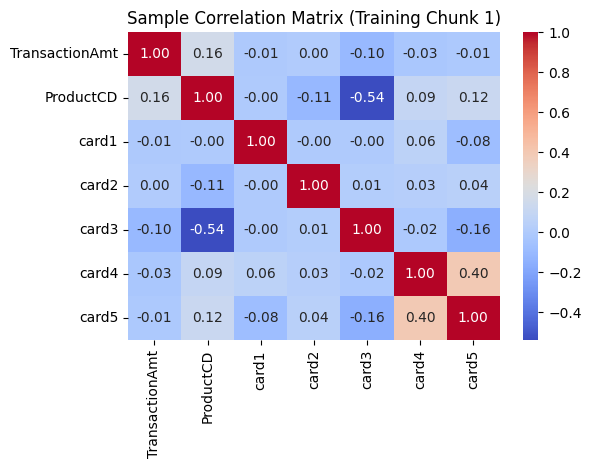

[2025-05-25 22:43:06] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:06] Event: analysis_end
[2025-05-25 22:43:06] Event: chunk_processing_complete
  ETL Chunk Num: 1
Processing chunk file 2/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_10.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 2 (shape: (50000, 433))...
    Yielding processed chunk 2 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:08] Event: etl_chunk_received
  ETL Chunk Num: 2
  Debug y_chunk_true 2: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:08] Predicting and evaluating on chunk 2...
[2025-05-25 22:43:09] Event: model_evaluation_on_chunk
  ETL Chunk Num: 2
  Chunk Accuracy: 0.9674
  Chunk 2 Evaluation: Accuracy=0.9674, F1-Weighted=0.9536
  Confusion Matrix:
[[48269    20]
 [ 1608   103]]


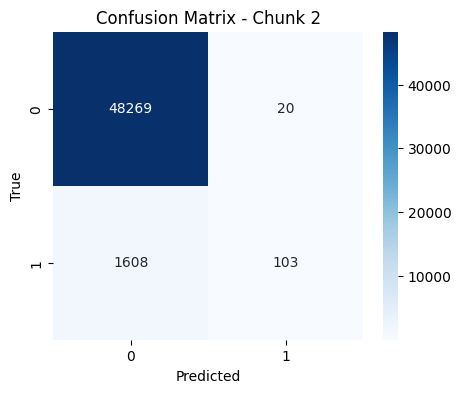

[2025-05-25 22:43:09] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 2) ---
Value Counts (True Labels):
isFraud
0    0.96578
1    0.03422
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.034220
std          0.181796
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:09] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 2) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       135.364335      3.415500   9949.222900    361.693060    152.777480
std        238.474328      1.302464   4938.056262    155.889346     10.505264
min          0.364000      0.000000   1013.0000

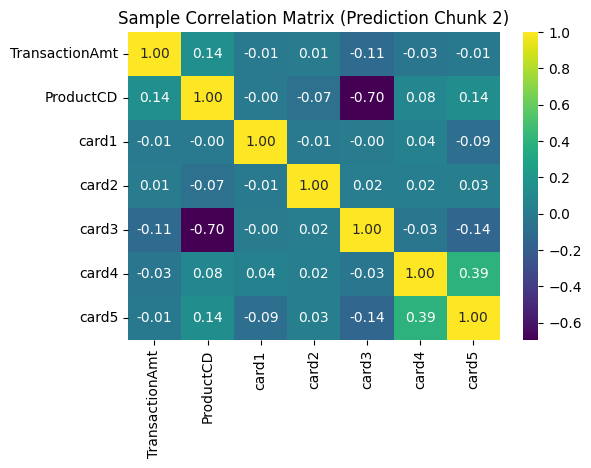

[2025-05-25 22:43:09] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:09] Event: analysis_end
[2025-05-25 22:43:09] Event: chunk_processing_complete
  ETL Chunk Num: 2
Processing chunk file 3/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_11.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 3 (shape: (50000, 433))...
    Yielding processed chunk 3 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:11] Event: etl_chunk_received
  ETL Chunk Num: 3
  Debug y_chunk_true 3: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:11] Predicting and evaluating on chunk 3...
[2025-05-25 22:43:11] Event: model_evaluation_on_chunk
  ETL Chunk Num: 3
  Chunk Accuracy: 0.9726
  Chunk 3 Evaluation: Accuracy=0.9726, F1-Weighted=0.9628
  Confusion Matrix:
[[48413    32]
 [ 1339   216]]


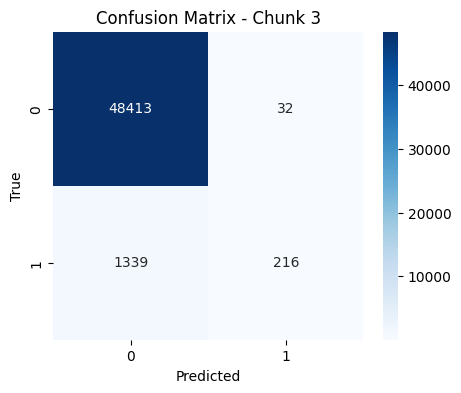

[2025-05-25 22:43:11] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 3) ---
Value Counts (True Labels):
isFraud
0    0.9689
1    0.0311
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.00000
mean         0.03110
std          0.17359
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: isFraud, dtype: float64
[2025-05-25 22:43:11] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 3) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       136.528131      3.345120   9971.222880    358.683000    152.853680
std        243.930486      1.346361   4863.857462    155.654559     10.853826
min          0.499000      0.000000   1004.000000    100.

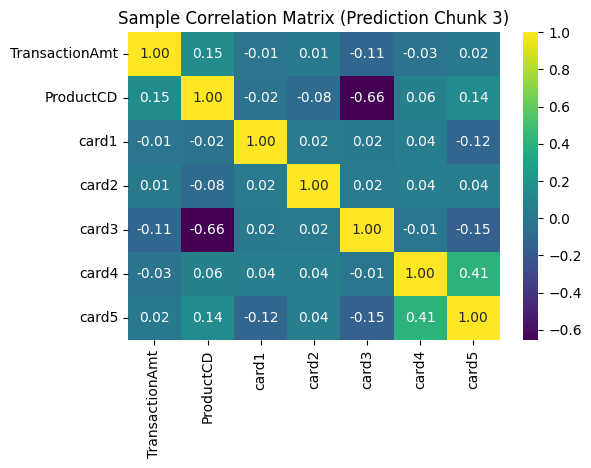

[2025-05-25 22:43:12] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:12] Event: analysis_end
[2025-05-25 22:43:12] Event: chunk_processing_complete
  ETL Chunk Num: 3
Processing chunk file 4/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_12.parquet
  Loaded chunk shape: (40540, 434)
  Transforming chunk from file 4 (shape: (40540, 433))...
    Yielding processed chunk 4 (X shape: (40540, 431), y shape: (40540,))
[2025-05-25 22:43:13] Event: etl_chunk_received
  ETL Chunk Num: 4
  Debug y_chunk_true 4: dtype=int64, shape=(40540,), unique (up to 5)=[0 1]
[2025-05-25 22:43:13] Predicting and evaluating on chunk 4...
[2025-05-25 22:43:13] Event: model_evaluation_on_chunk
  ETL Chunk Num: 4
  Chunk Accuracy: 0.9661
  Chunk 4 Evaluation: Accuracy=0.9661, F1-Weighted=0.9537
  Confusion Matrix:
[[38943    10]
 [ 1365   222]]


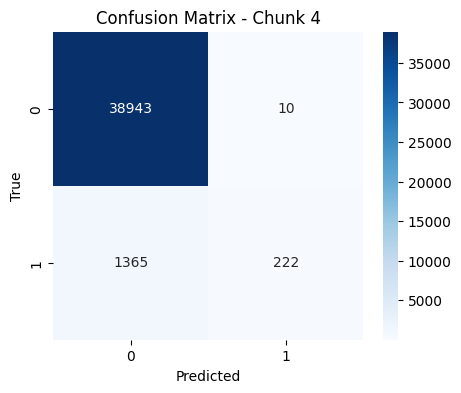

[2025-05-25 22:43:13] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 4) ---
Value Counts (True Labels):
isFraud
0    0.960853
1    0.039147
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    40540.000000
mean         0.039147
std          0.193946
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:13] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 4) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    40540.000000  40540.000000  40540.000000  40540.000000  40540.000000
mean       138.929396      3.386088  10126.575358    364.448446    152.731154
std        251.463630      1.306927   4937.835009    154.958038     10.725976
min          0.615000      0.000000   1008.00

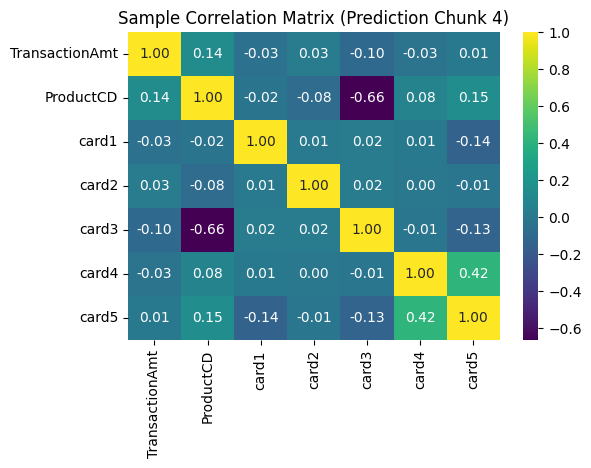

[2025-05-25 22:43:14] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:14] Event: analysis_end
[2025-05-25 22:43:14] Event: chunk_processing_complete
  ETL Chunk Num: 4
Processing chunk file 5/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_2.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 5 (shape: (50000, 433))...
    Yielding processed chunk 5 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:16] Event: etl_chunk_received
  ETL Chunk Num: 5
  Debug y_chunk_true 5: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:16] Predicting and evaluating on chunk 5...
[2025-05-25 22:43:16] Event: model_evaluation_on_chunk
  ETL Chunk Num: 5
  Chunk Accuracy: 0.9793
  Chunk 5 Evaluation: Accuracy=0.9793, F1-Weighted=0.9720
  Confusion Matrix:
[[48779    17]
 [ 1018   186]]


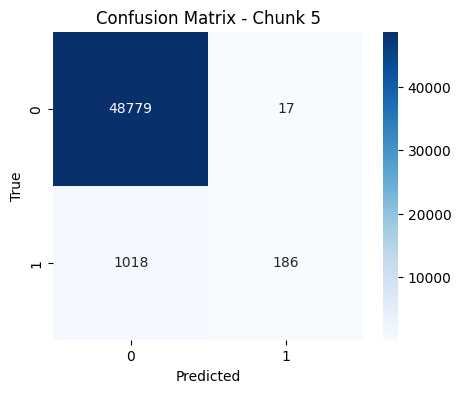

[2025-05-25 22:43:16] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 5) ---
Value Counts (True Labels):
isFraud
0    0.97592
1    0.02408
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.024080
std          0.153299
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:16] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 5) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       133.363488      2.566340   9844.162940    375.051360    153.669660
std        198.691804      1.517144   4962.130169    158.269984     11.766945
min          1.000000      0.000000   1005.0000

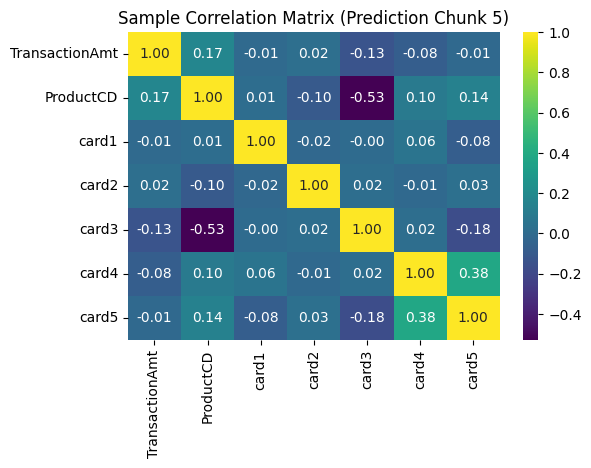

[2025-05-25 22:43:16] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:16] Event: analysis_end
[2025-05-25 22:43:16] Event: chunk_processing_complete
  ETL Chunk Num: 5
Processing chunk file 6/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_3.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 6 (shape: (50000, 433))...
    Yielding processed chunk 6 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:17] Event: etl_chunk_received
  ETL Chunk Num: 6
  Debug y_chunk_true 6: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:17] Predicting and evaluating on chunk 6...
[2025-05-25 22:43:18] Event: model_evaluation_on_chunk
  ETL Chunk Num: 6
  Chunk Accuracy: 0.9755
  Chunk 6 Evaluation: Accuracy=0.9755, F1-Weighted=0.9668
  Confusion Matrix:
[[48571    20]
 [ 1204   205]]


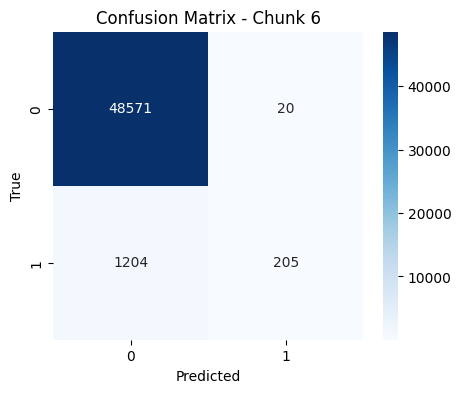

[2025-05-25 22:43:18] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 6) ---
Value Counts (True Labels):
isFraud
0    0.97182
1    0.02818
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.028180
std          0.165488
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:18] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 6) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       122.833722      2.784240   9843.877880    367.826780    154.096660
std        189.036579      1.555499   4882.679193    157.858327     12.406999
min          2.215000      0.000000   1006.0000

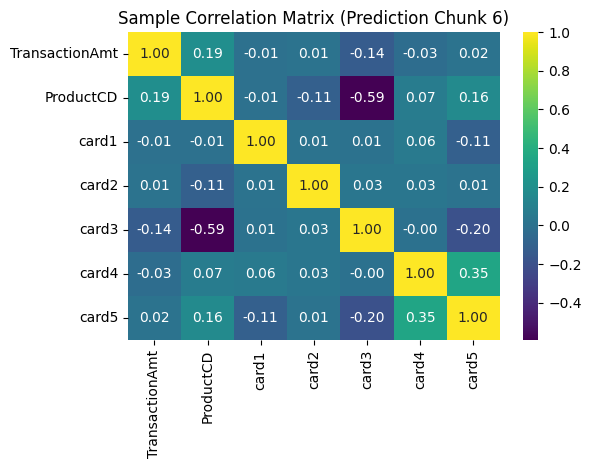

[2025-05-25 22:43:18] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:18] Event: analysis_end
[2025-05-25 22:43:18] Event: chunk_processing_complete
  ETL Chunk Num: 6
Processing chunk file 7/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_4.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 7 (shape: (50000, 433))...
    Yielding processed chunk 7 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:20] Event: etl_chunk_received
  ETL Chunk Num: 7
  Debug y_chunk_true 7: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:20] Predicting and evaluating on chunk 7...
[2025-05-25 22:43:20] Event: model_evaluation_on_chunk
  ETL Chunk Num: 7
  Chunk Accuracy: 0.964
  Chunk 7 Evaluation: Accuracy=0.9640, F1-Weighted=0.9505
  Confusion Matrix:
[[47940     6]
 [ 1793   261]]


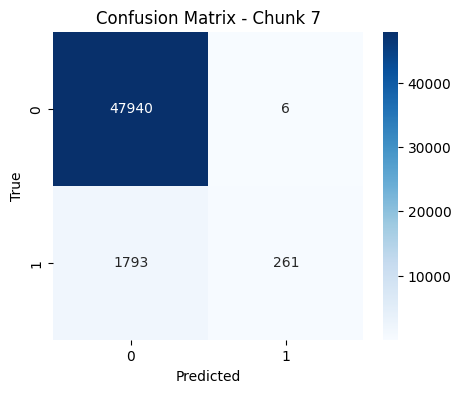

[2025-05-25 22:43:20] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 7) ---
Value Counts (True Labels):
isFraud
0    0.95892
1    0.04108
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.041080
std          0.198477
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:20] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 7) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       134.995130      3.404880   9852.521800    361.860680    152.661720
std        227.614457      1.322069   4906.719151    156.333707     10.945575
min          0.583000      0.000000   1001.0000

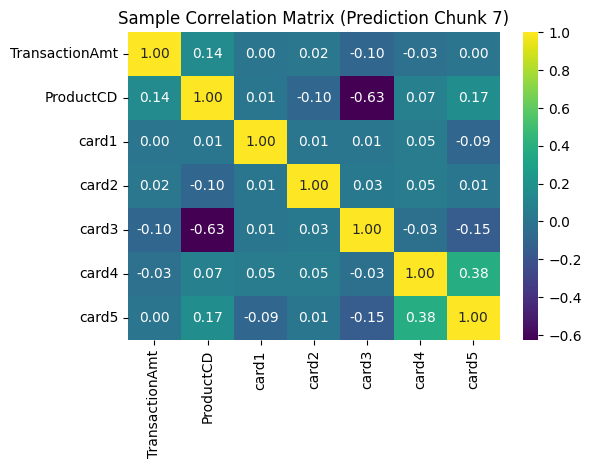

[2025-05-25 22:43:21] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:21] Event: analysis_end
[2025-05-25 22:43:21] Event: chunk_processing_complete
  ETL Chunk Num: 7
Processing chunk file 8/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_5.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 8 (shape: (50000, 433))...
    Yielding processed chunk 8 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:22] Event: etl_chunk_received
  ETL Chunk Num: 8
  Debug y_chunk_true 8: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:22] Predicting and evaluating on chunk 8...
[2025-05-25 22:43:22] Event: model_evaluation_on_chunk
  ETL Chunk Num: 8
  Chunk Accuracy: 0.9633
  Chunk 8 Evaluation: Accuracy=0.9633, F1-Weighted=0.9499
  Confusion Matrix:
[[47877    14]
 [ 1821   288]]


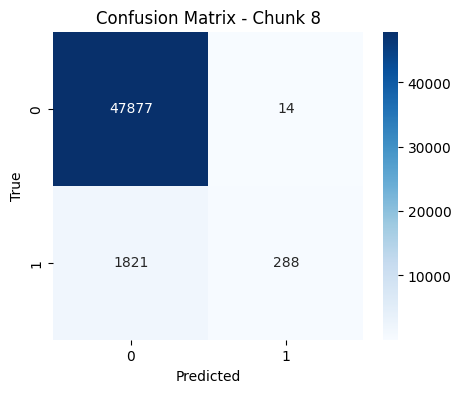

[2025-05-25 22:43:22] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 8) ---
Value Counts (True Labels):
isFraud
0    0.95782
1    0.04218
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.042180
std          0.201002
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:22] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 8) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       137.583068      3.397560   9827.844980    360.441940    152.972600
std        249.011232      1.340381   4894.674408    156.109722     11.296405
min          0.292000      0.000000   1000.0000

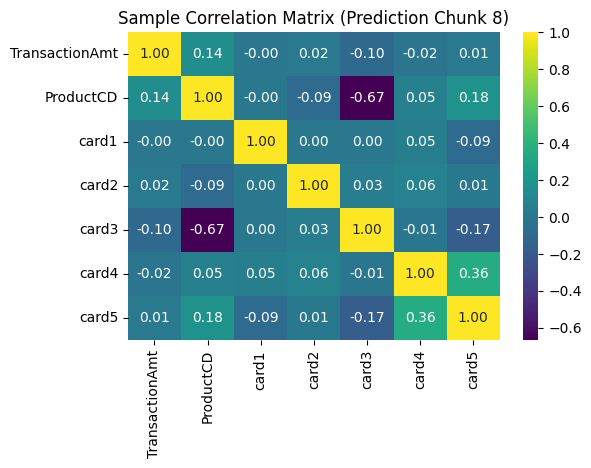

[2025-05-25 22:43:23] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:23] Event: analysis_end
[2025-05-25 22:43:23] Event: chunk_processing_complete
  ETL Chunk Num: 8
Processing chunk file 9/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_6.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 9 (shape: (50000, 433))...
    Yielding processed chunk 9 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:24] Event: etl_chunk_received
  ETL Chunk Num: 9
  Debug y_chunk_true 9: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:24] Predicting and evaluating on chunk 9...
[2025-05-25 22:43:24] Event: model_evaluation_on_chunk
  ETL Chunk Num: 9
  Chunk Accuracy: 0.9656
  Chunk 9 Evaluation: Accuracy=0.9656, F1-Weighted=0.9528
  Confusion Matrix:
[[48020    14]
 [ 1708   258]]


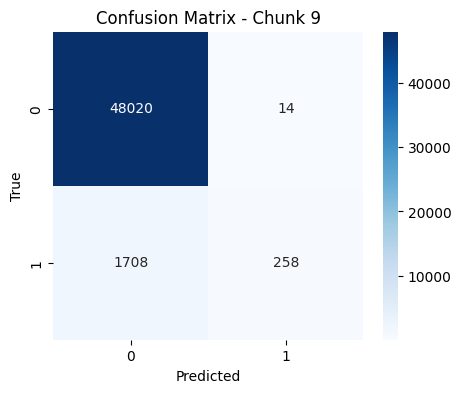

[2025-05-25 22:43:24] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 9) ---
Value Counts (True Labels):
isFraud
0    0.96068
1    0.03932
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.039320
std          0.194357
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:24] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 9) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       137.418128      3.304000   9881.082200    363.241900    153.400780
std        317.495395      1.406593   4936.443329    156.531152     11.744965
min          0.786000      0.000000   1008.0000

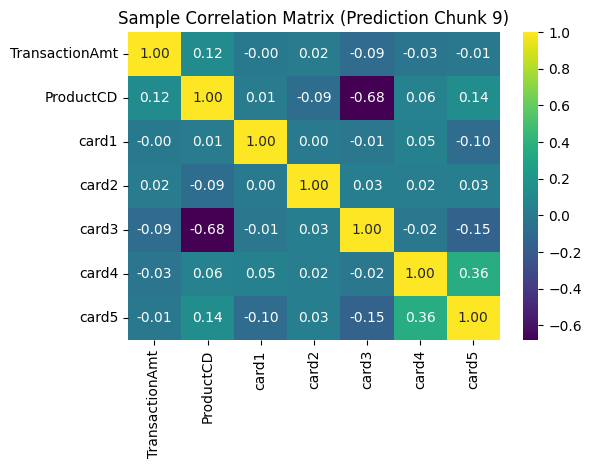

[2025-05-25 22:43:25] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:25] Event: analysis_end
[2025-05-25 22:43:25] Event: chunk_processing_complete
  ETL Chunk Num: 9
Processing chunk file 10/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_7.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 10 (shape: (50000, 433))...
    Yielding processed chunk 10 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:26] Event: etl_chunk_received
  ETL Chunk Num: 10
  Debug y_chunk_true 10: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:26] Predicting and evaluating on chunk 10...
[2025-05-25 22:43:26] Event: model_evaluation_on_chunk
  ETL Chunk Num: 10
  Chunk Accuracy: 0.9671
  Chunk 10 Evaluation: Accuracy=0.9671, F1-Weighted=0.9532
  Confusion Matrix:
[[48236    11]
 [ 1633   120]]


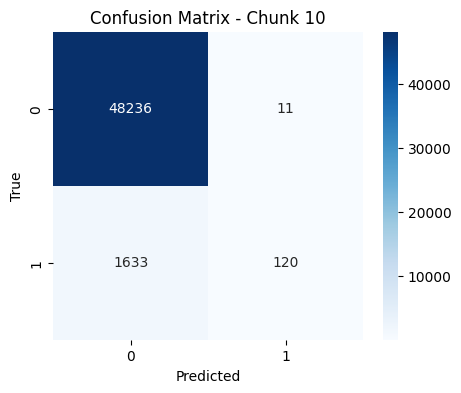

[2025-05-25 22:43:26] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 10) ---
Value Counts (True Labels):
isFraud
0    0.96494
1    0.03506
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.035060
std          0.183933
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:26] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 10) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       146.053374      3.458040   9857.527420    355.599160    152.714860
std        246.815541      1.287584   4832.223687    154.090966     10.610816
min          0.498000      0.000000   1011.00

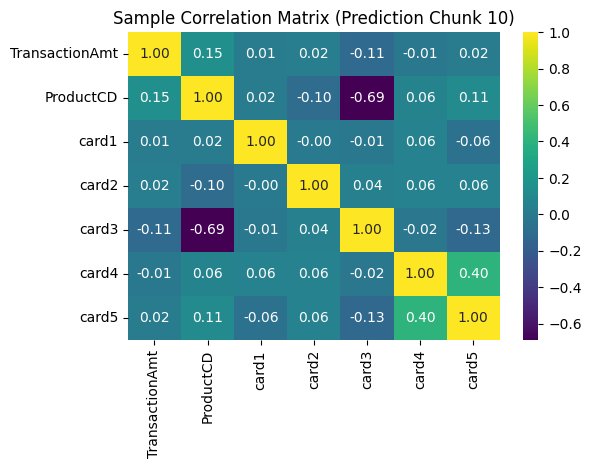

[2025-05-25 22:43:26] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:26] Event: analysis_end
[2025-05-25 22:43:26] Event: chunk_processing_complete
  ETL Chunk Num: 10
Processing chunk file 11/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_8.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 11 (shape: (50000, 433))...
    Yielding processed chunk 11 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:27] Event: etl_chunk_received
  ETL Chunk Num: 11
  Debug y_chunk_true 11: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:27] Predicting and evaluating on chunk 11...
[2025-05-25 22:43:27] Event: model_evaluation_on_chunk
  ETL Chunk Num: 11
  Chunk Accuracy: 0.9635
  Chunk 11 Evaluation: Accuracy=0.9635, F1-Weighted=0.9495
  Confusion Matrix:
[[47940     9]
 [ 1815   236]]


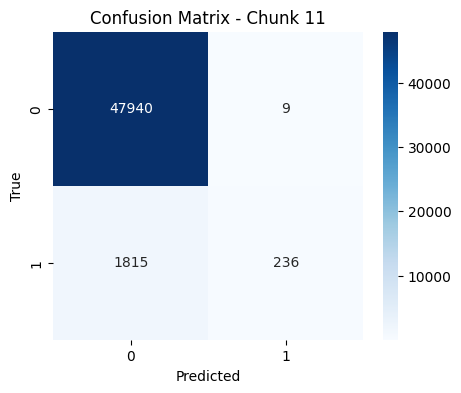

[2025-05-25 22:43:28] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 11) ---
Value Counts (True Labels):
isFraud
0    0.95898
1    0.04102
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.041020
std          0.198338
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:28] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 11) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       135.292833      3.293180   9906.738640    360.089400    153.775380
std        233.426195      1.440731   4901.987224    157.203373     12.245703
min          0.251000      0.000000   1004.00

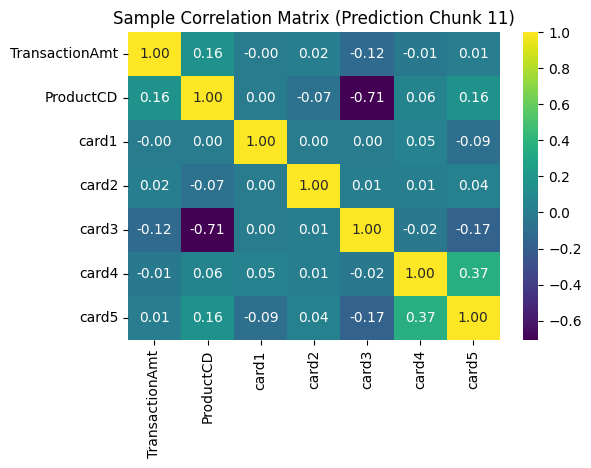

[2025-05-25 22:43:28] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:28] Event: analysis_end
[2025-05-25 22:43:28] Event: chunk_processing_complete
  ETL Chunk Num: 11
Processing chunk file 12/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_9.parquet
  Loaded chunk shape: (50000, 434)
  Transforming chunk from file 12 (shape: (50000, 433))...
    Yielding processed chunk 12 (X shape: (50000, 431), y shape: (50000,))
[2025-05-25 22:43:29] Event: etl_chunk_received
  ETL Chunk Num: 12
  Debug y_chunk_true 12: dtype=int64, shape=(50000,), unique (up to 5)=[0 1]
[2025-05-25 22:43:29] Predicting and evaluating on chunk 12...
[2025-05-25 22:43:29] Event: model_evaluation_on_chunk
  ETL Chunk Num: 12
  Chunk Accuracy: 0.9666
  Chunk 12 Evaluation: Accuracy=0.9666, F1-Weighted=0.9551
  Confusion Matrix:
[[48051    42]
 [ 1626   281]]


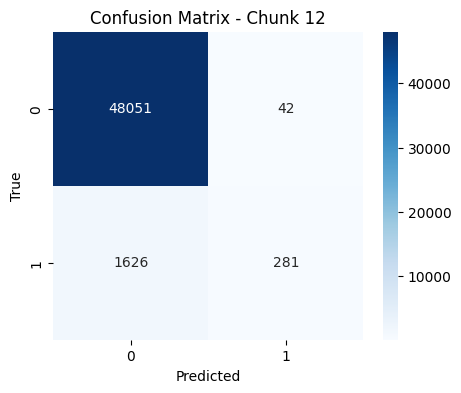

[2025-05-25 22:43:29] Event: analysis_start

--- Univariate Analysis on y_chunk_true (Prediction Chunk 12) ---
Value Counts (True Labels):
isFraud
0    0.96186
1    0.03814
Name: proportion, dtype: float64

Descriptive Stats for y_chunk_true:
count    50000.000000
mean         0.038140
std          0.191536
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
[2025-05-25 22:43:29] Event: univariate_y_analysis_complete

--- Multivariate Analysis on X_chunk (Prediction Chunk 12) ---
Descriptive Stats for a few numeric features in X_chunk (Prediction):
       TransactionAmt     ProductCD         card1         card2         card3
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       134.579597      3.330580   9854.511500    356.570140    153.693880
std        238.635277      1.406221   4851.733822    156.967552     11.820405
min          0.940000      0.000000   1006.00

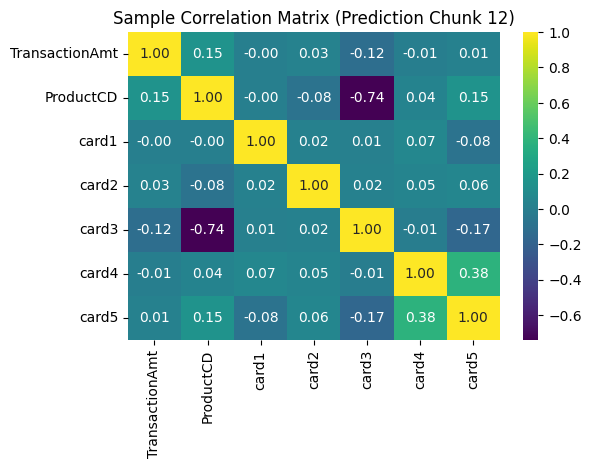

[2025-05-25 22:43:30] Event: multivariate_X_analysis_complete
[2025-05-25 22:43:30] Event: analysis_end
[2025-05-25 22:43:30] Event: chunk_processing_complete
  ETL Chunk Num: 12

Finished yielding processed chunks. Total yielded: 12

--- Overall Evaluation (across 540540 predicted samples) ---
Overall Accuracy: 0.9683
Overall F1-Weighted: 0.9565
Overall Confusion Matrix:
[[521039    195]
 [ 16930   2376]]


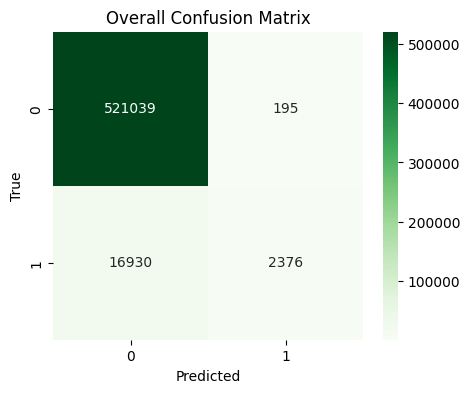

[2025-05-25 22:43:31] Event: overall_evaluation_complete
[2025-05-25 22:43:31] Event: finish
  Message: Notebook generator finished processing 12 ETL chunks.

Pipeline Finished.
Final Model (trained on first chunk): RandomForestClassifier(max_depth=8, n_estimators=50, n_jobs=-1, random_state=42)


In [21]:
# reload_utils() # Uncomment if you have this utility

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score # Added confusion_matrix
import seaborn as sns # For heatmap of confusion matrix and correlation matrix
import matplotlib.pyplot as plt # For displaying plots
import gc
import time

# Assuming etl_chain.py with run_custom_etl_generator is in your Python path
from etl_chain import run_custom_etl_generator #

# --- Define the main processing generator for the notebook ---
def notebook_chunk_processor_generator(
    etl_config,
    model_class,
    model_params,
    # training_epochs_per_etl_chunk is not used for this RF strategy
    _training_epochs_ignored=1
):
    """
    Generator that trains a model on the first processed ETL chunk
    and then predicts and evaluates on subsequent chunks.
    Includes basic EDA per predicted chunk.
    """
    print(f"--- Initializing Notebook Processing Generator (Train on First Chunk) ---")
    # 1. Initialize the ETL data stream generator
    processed_data_stream = run_custom_etl_generator(**etl_config) #

    # 2. Initialize Model - it will be trained on the first chunk only
    model = model_class(**model_params)
    model_is_trained = False
    final_model_state = "Model not trained yet."

    etl_chunk_counter = 0
    target_column_name = etl_config.get("target_column", "isFraud")

    # Store all true y and predicted y for a final overall evaluation (optional)
    y_true_all_predictions = []
    y_pred_all_predictions = []

    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting to process ETL chunks...")
    for X_chunk, y_chunk_true in processed_data_stream: # y_chunk_true is the true label for the chunk
        etl_chunk_counter += 1
        start_time_chunk_processing = time.time()

        event_data = {
            "event": "etl_chunk_received",
            "etl_chunk_num": etl_chunk_counter,
            "X_shape": X_chunk.shape if X_chunk is not None else "N/A",
            "y_shape": y_chunk_true.shape if y_chunk_true is not None else "N/A"
        }
        yield event_data
        
        if y_chunk_true is not None:
             print(f"  Debug y_chunk_true {etl_chunk_counter}: dtype={y_chunk_true.dtype}, shape={y_chunk_true.shape}, unique (up to 5)={np.unique(y_chunk_true)[:5]}")
        else:
             print(f"  Debug y_chunk_true {etl_chunk_counter}: y_chunk_true is None (target: {target_column_name})")


        if X_chunk is None or X_chunk.empty:
            yield {
                "event": "processing_skipped_empty_X_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "reason": "X_chunk is None or empty."
            }
            if X_chunk is not None: del X_chunk
            if y_chunk_true is not None: del y_chunk_true
            gc.collect()
            continue

        # --- Train on the FIRST valid chunk ---
        if not model_is_trained:
            if y_chunk_true is None or y_chunk_true.empty:
                yield {
                    "event": "model_training_skipped_no_y_on_first_chunk",
                    "etl_chunk_num": etl_chunk_counter,
                    "reason": "y_chunk_true is None or empty on the first chunk intended for training."
                }
                # Decide if you want to try training on the *next* chunk or stop.
                # For this example, we'll effectively wait for the first chunk that has y.
            else:
                print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Training model on first chunk (ETL Chunk Num: {etl_chunk_counter})...")
                try:
                    fit_start_time = time.time()
                    model.fit(X_chunk, y_chunk_true)
                    fit_duration = time.time() - fit_start_time
                    model_is_trained = True
                    final_model_state = model # Store the trained model
                    yield {
                        "event": "model_trained_on_first_chunk",
                        "etl_chunk_num": etl_chunk_counter,
                        "status": "success",
                        "fit_duration_seconds": round(fit_duration, 2)
                    }
                    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Model successfully trained in {fit_duration:.2f}s.")

                    # --- Perform analysis on the training chunk (Chunk 1) ---
                    yield { "event": "analysis_start", "on_chunk": etl_chunk_counter, "type": "training_chunk" }
                    # Univariate analysis on y_chunk_true (training target)
                    if y_chunk_true is not None and not y_chunk_true.empty:
                        print(f"\n--- Univariate Analysis on y_chunk_true (Training Chunk {etl_chunk_counter}) ---")
                        print("Value Counts:")
                        print(y_chunk_true.value_counts(normalize=True))
                        print("\nDescriptive Stats for y_chunk_true:")
                        print(y_chunk_true.describe())
                        yield {"event": "univariate_y_analysis_complete", "chunk_num": etl_chunk_counter}
                    
                    # Multivariate analysis on X_chunk (training features)
                    if X_chunk is not None and not X_chunk.empty:
                        print(f"\n--- Multivariate Analysis on X_chunk (Training Chunk {etl_chunk_counter}) ---")
                        numeric_cols_train = X_chunk.select_dtypes(include=np.number).columns
                        if not numeric_cols_train.empty:
                            print("Descriptive Stats for a few numeric features in X_chunk (Training):")
                            print(X_chunk[numeric_cols_train[:min(5, len(numeric_cols_train))]].describe())
                            
                            # Correlation matrix for a small subset
                            sample_corr_cols_train = numeric_cols_train[:min(7, len(numeric_cols_train))]
                            if len(sample_corr_cols_train) > 1:
                                plt.figure(figsize=(6, 4))
                                sns.heatmap(X_chunk[sample_corr_cols_train].corr(), annot=True, fmt=".2f", cmap="coolwarm")
                                plt.title(f"Sample Correlation Matrix (Training Chunk {etl_chunk_counter})")
                                plt.show()
                        else:
                            print("No numeric columns found in X_chunk for multivariate analysis.")
                        yield {"event": "multivariate_X_analysis_complete", "chunk_num": etl_chunk_counter}
                    yield { "event": "analysis_end", "on_chunk": etl_chunk_counter }


                except Exception as e:
                    yield {
                        "event": "model_training_error_on_first_chunk",
                        "etl_chunk_num": etl_chunk_counter,
                        "error": str(e)
                    }
                    final_model_state = f"Model training failed: {str(e)}"
                    # If training fails on the first chunk, we might want to stop.
                    del X_chunk; del y_chunk_true; gc.collect(); return

        # --- Predict and Evaluate on SUBSEQUENT chunks (or current chunk if it's also the first one post-training) ---
        else: # model_is_trained is True
            if target_column_name == "placeholder" or y_chunk_true is None:
                # This case is for predicting on test data where true labels (y_chunk_true) are not available
                print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Predicting on chunk {etl_chunk_counter} (no true labels available)...")
                y_chunk_pred = model.predict(X_chunk)
                # y_chunk_pred_proba = model.predict_proba(X_chunk) # If needed
                yield {
                    "event": "model_prediction_on_chunk",
                    "etl_chunk_num": etl_chunk_counter,
                    "predictions_shape": y_chunk_pred.shape,
                    # "predicted_labels": y_chunk_pred[:10], # Sample predictions
                    # "predicted_probas": y_chunk_pred_proba[:10] if hasattr(model, 'predict_proba') else "N/A"
                }
                # No evaluation metrics if y_chunk_true is None

            elif y_chunk_true is not None and not y_chunk_true.empty: # y_chunk_true is available for evaluation
                print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Predicting and evaluating on chunk {etl_chunk_counter}...")
                y_chunk_pred = model.predict(X_chunk)
                
                # Store for overall metrics if needed
                y_true_all_predictions.extend(y_chunk_true.tolist())
                y_pred_all_predictions.extend(y_chunk_pred.tolist())

                accuracy = accuracy_score(y_chunk_true, y_chunk_pred)
                f1 = f1_score(y_chunk_true, y_chunk_pred, average='weighted', zero_division=0)
                cm = confusion_matrix(y_chunk_true, y_chunk_pred, labels=model.classes_ if hasattr(model, 'classes_') else np.unique(y_chunk_true))

                yield {
                    "event": "model_evaluation_on_chunk",
                    "etl_chunk_num": etl_chunk_counter,
                    "accuracy": round(accuracy, 4),
                    "f1_score_weighted": round(f1, 4),
                    # "confusion_matrix": cm.tolist() #tolist is more JSON friendly if needed
                }
                print(f"  Chunk {etl_chunk_counter} Evaluation: Accuracy={accuracy:.4f}, F1-Weighted={f1:.4f}")
                print("  Confusion Matrix:")
                # For better display in notebook, print it or use seaborn heatmap
                print(cm)
                if len(cm) > 1 : # Only plot if there's something to plot
                    plt.figure(figsize=(5,4))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                                xticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto', 
                                yticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.title(f'Confusion Matrix - Chunk {etl_chunk_counter}')
                    plt.show()
                
                # --- Perform analysis on the prediction chunk ---
                yield { "event": "analysis_start", "on_chunk": etl_chunk_counter, "type": "prediction_chunk" }
                # Univariate analysis on y_chunk_true (prediction target)
                print(f"\n--- Univariate Analysis on y_chunk_true (Prediction Chunk {etl_chunk_counter}) ---")
                print("Value Counts (True Labels):")
                print(y_chunk_true.value_counts(normalize=True))
                print("\nDescriptive Stats for y_chunk_true:")
                print(y_chunk_true.describe())
                yield {"event": "univariate_y_analysis_complete", "chunk_num": etl_chunk_counter}
                
                # Multivariate analysis on X_chunk (prediction features)
                print(f"\n--- Multivariate Analysis on X_chunk (Prediction Chunk {etl_chunk_counter}) ---")
                numeric_cols_pred = X_chunk.select_dtypes(include=np.number).columns
                if not numeric_cols_pred.empty:
                    print("Descriptive Stats for a few numeric features in X_chunk (Prediction):")
                    print(X_chunk[numeric_cols_pred[:min(5, len(numeric_cols_pred))]].describe())
                    
                    sample_corr_cols_pred = numeric_cols_pred[:min(7, len(numeric_cols_pred))]
                    if len(sample_corr_cols_pred) > 1:
                        plt.figure(figsize=(6, 4))
                        sns.heatmap(X_chunk[sample_corr_cols_pred].corr(), annot=True, fmt=".2f", cmap="viridis")
                        plt.title(f"Sample Correlation Matrix (Prediction Chunk {etl_chunk_counter})")
                        plt.show()
                else:
                    print("No numeric columns found in X_chunk for multivariate analysis.")
                yield {"event": "multivariate_X_analysis_complete", "chunk_num": etl_chunk_counter}
                yield { "event": "analysis_end", "on_chunk": etl_chunk_counter }

            else: # y_chunk_true is empty, though X_chunk was not. Should be rare.
                yield {
                    "event": "evaluation_skipped_empty_y",
                    "etl_chunk_num": etl_chunk_counter,
                    "reason": "y_chunk_true is empty for evaluation, though X_chunk was present."
                }
        
        duration_chunk_processing = time.time() - start_time_chunk_processing
        yield {
            "event": "chunk_processing_complete", # Generic event for end of chunk ops
            "etl_chunk_num": etl_chunk_counter,
            "duration_seconds": round(duration_chunk_processing, 2)
        }
        
        del X_chunk
        if y_chunk_true is not None: del y_chunk_true
        gc.collect()

    # Optional: Final overall evaluation if predictions were collected
    if y_true_all_predictions and y_pred_all_predictions:
        overall_accuracy = accuracy_score(y_true_all_predictions, y_pred_all_predictions)
        overall_f1 = f1_score(y_true_all_predictions, y_pred_all_predictions, average='weighted', zero_division=0)
        print(f"\n--- Overall Evaluation (across {len(y_pred_all_predictions)} predicted samples) ---")
        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print(f"Overall F1-Weighted: {overall_f1:.4f}")
        print("Overall Confusion Matrix:")
        overall_cm = confusion_matrix(y_true_all_predictions, y_pred_all_predictions, labels=model.classes_ if hasattr(model, 'classes_') else np.unique(y_true_all_predictions))
        print(overall_cm)
        if len(overall_cm) > 1:
            plt.figure(figsize=(5,4))
            sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Greens',
                        xticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto', 
                        yticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Overall Confusion Matrix')
            plt.show()
        yield {
            "event": "overall_evaluation_complete",
            "total_samples_evaluated": len(y_true_all_predictions),
            "overall_accuracy": round(overall_accuracy, 4),
            "overall_f1_weighted": round(overall_f1, 4),
        }


    yield {
        "event": "finish",
        "message": f"Notebook generator finished processing {etl_chunk_counter} ETL chunks.",
        "final_model_state": final_model_state
    }


# --- How to use the notebook generator ---

if 'output_chunk_dir' in locals() and 'file_format' in locals() and 'target_column' in locals():
    etl_config = {
        "output_chunk_dir_path": output_chunk_dir,
        "file_format": file_format,
        "target_column": target_column,
        "num_chunks_to_fit_on": 1, # RawTransformer will be fit on this many files from output_chunk_dir
        "num_processed_chunks_to_yield": "all", # Process all available pre-merged chunks
        "drop_na_during_load": False
    }

    model_conf = {
        "model_class": RandomForestClassifier,
        "model_params": {
            'n_estimators': 50, # Reduced for quicker demonstration
            'max_depth': 8,    # Reduced for quicker demonstration
            'random_state': 42,
            'n_jobs': -1
        }
        # training_epochs_per_etl_chunk is ignored by this version of the generator
    }

    pipeline_gen = notebook_chunk_processor_generator(
        etl_config=etl_config,
        **model_conf
    )

    final_model_trained_on_first_chunk = None
    print(f"\n--- Starting Notebook Pipeline (RF Train on First Chunk) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    for result in pipeline_gen:
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Event: {result.get('event')}")
        if 'etl_chunk_num' in result: print(f"  ETL Chunk Num: {result.get('etl_chunk_num')}")
        # Add more detailed logging based on the event data as needed
        if 'message' in result: print(f"  Message: {result.get('message')}")
        if 'reason' in result: print(f"  Reason: {result.get('reason')}")
        if 'status' in result: print(f"  Status: {result.get('status')}")
        if 'error' in result: print(f"  ERROR: {result.get('error')}")
        if 'accuracy' in result: print(f"  Chunk Accuracy: {result.get('accuracy')}")

        if result.get('event') == 'finish':
            final_model_trained_on_first_chunk = result.get('final_model_state')
            print("\nPipeline Finished.")
            if isinstance(final_model_trained_on_first_chunk, RandomForestClassifier):
                print("Final Model (trained on first chunk):", final_model_trained_on_first_chunk)
            else:
                print("Final Model State:", final_model_trained_on_first_chunk)
else:
    print("Please ensure 'output_chunk_dir', 'file_format', and 'target_column' are defined in your notebook scope to run this.")

In [31]:
# reload_utils()
# import pandas as pd
# from etl_chain import run_custom_etl_streaming, run_custom_etl_generator
# # --- 1. Run the ETL pipeline from etl_chain.py ---
# print(f"Starting ETL process for dataset: {local_dataset_name} with target: {target_column}")
# try:
#     etl_result = run_custom_etl_streaming(dataset_name=local_dataset_name, target_column=target_column)
#     X_train_unprocessed = etl_result.get("X_train_unprocessed")
#     X_train = etl_result.get("X_train")
#     y_train = etl_result.get("y_train")
#     X_val = etl_result.get("X_val")
#     y_val = etl_result.get("y_val")    
# except Exception as e:
#     print(f"An error occurred during the ETL process: {e}")
#     raise

# from utils.etl import validate_X_schema, validate_y_schema
# validate_X_schema(X_train)
# validate_X_schema(X_val)
# validate_y_schema(y_train)
# validate_y_schema(y_val)
# # X_train.isna().sum()
# print(X_train_unprocessed.shape)
# print(X_train.shape)
# print(X_val.shape)

# from utils.eval import evaluate_feature_feedback
# feedback = evaluate_feature_feedback(
#     X_train,
#     y_train,
#     X_val,
#     y_val,
   
# )


🔁 Reloaded cis_fraud.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Starting ETL process for dataset: ieee-fraud-detection with target: isFraud
Using Jovyan data directory: /home/jovyan/data
Attempting to load from: /home/jovyan/data/ieee-fraud-detection/raw/train_identity.csv
Dataset loaded successfully. Shape: (144233, 41)
An error occurred during the ETL process: Target column 'isFraud' not found or y_raw is None for training.


ValueError: Target column 'isFraud' not found or y_raw is None for training.

In [ ]:
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model, \
                        conditionally_encode_labels
import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
model_configs = {
    # "decision_tree": [
    #     {"criterion": c, "max_depth": d, "min_samples_split": m, "min_samples_leaf": l}
    #     for c in ["gini", "entropy"]
    #     for d in [None, 5, 10]
    #     for m in [2, 5]
    #     for l in [1, 2]
    # ],

    "random_forest": [
        {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
        for n in [50, 200, 350]
        for d in [None, 10,15]
        for f in ["sqrt", "log2"]
        for m in [2, 5]
    ],

    # "logistic_regression": [
    #     {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
    #     for p in ["l1", "l2"]
    #     for c in [0.01, 0.1, 1.0]
    # ],

    "xgboost": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
        for n in [200]
        for d in [5, 7]
        for lr in [0.005, 0.1]
        for s in [0.8, 1.0]
        for cbt in [0.8, 1.0]
    ],

    "lightgbm": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
        for n in [100, 200]
        for d in [-1, 10]
        for lr in [0.01, 0.1]
        for nl in [31, 50]
        for mcs in [10, 20]
    ],
    # "svm": [
    #     {"C": c, "kernel": k, "gamma": g}
    #     for c in [0.1, 1.0, 10.0]
    #     for k in ["linear", "rbf", "poly"]
    #     for g in ["scale", "auto"]
    # ],

    # "naive_bayes": [
    #     {"var_smoothing": vs}
    #     for vs in [1e-9, 1e-8, 1e-7]
    # ],

    # "knn": [
    #     {"n_neighbors": k, "weights": w, "metric": m}
    #     for k in [ 5, 7]
    #     for w in ["uniform", "distance"]
    #     for m in ["euclidean", "manhattan"]
    # ],
    # "neural_net": [
    #     {
    #         "model_type": mt,
    #         "hidden": h,
    #         "dropout": d,
    #         "activation": act,
    #         "batch_norm": bn,
    #         "lr": lr,
    #         "num_layers": nl
    #     }
    #     for mt in ["mlp", "lstm", "cnn"]
    #     for h in [32, 64]
    #     for d in [0.0, 0.3]
    #     for act in ["relu", "tanh"]
    #     for bn in [False, True]
    #     for lr in [.005, 0.001, .05, 0.01, .05]
    #     for nl in [1, 2, 3,4]
    # ],
}

mlflow.set_experiment(f"kaggle_{local_dataset_name}")
print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish()
        # === Init Experiment | MLflow and W&B ===
        run_name = f"{etl_result['etl_version']}_{model_name}_{params}"
        run = mlflow.start_run(run_name=run_name)
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        mlflow.log_param("etl_version", etl_result['etl_version'])
        mlflow.log_param("etl_description", etl_result['etl_description'])
        print("Started MLflow run:", run.info.run_id)
        wandb.init(
            project=f"kaggle_{local_dataset_name}",
            name=run_name,
            config={
                **params,
                "model_name": model_name,
                "task_type": task_type,
                "perf_eval_metric": perf_eval_metric,
                "etl_version": etl_result['etl_version'],
                "etl_description": etl_result['etl_description']
            }
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multiclass_classification" else 1
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            y_train_nn, y_val_nn, label_encoder, label_encoder_applied = conditionally_encode_labels(y_train, y_val)
            model, y_pred = train_nn_model(
                model, X_train, y_train_nn, X_val, y_val_nn,
                epochs=20,
                lr = lr,
                task_type=task_type,
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
            )
            if label_encoder_applied:
                y_pred = label_encoder.inverse_transform(y_pred)
            print("✅ Finished training neural net")

        else:
            model = get_sklearn_model(model_name, **params)
            trained_model, y_pred = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type)
        log_final_metrics(eval_metrics)
        # commented out to reduced write2dis
        # log_model_artifact(trained_model, model_name, framework="torch" if model_name == "neural_net" else "sklearn")

        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()


In [7]:
# import pandas as pd
# reload_utils()
# from etl_chain import run_custom_etl_streaming
# from utils.models import get_sklearn_model 
# from utils.train import train_sklearn_model 
# from utils.submission import create_submission_file 

# # --- 1. Run the ETL pipeline from etl_chain.py ---
# print(f"Starting ETL process for dataset: {local_dataset_name} with target: {target_column}")
# try:
#     etl_result = run_custom_etl_streaming(dataset_name=local_dataset_name, 
#                                           target_column=target_column,
#                                          test_split = .01)
    
#     X_train = etl_result.get("X_train")
#     y_train = etl_result.get("y_train")
#     X_val = etl_result.get("X_val")
#     y_val = etl_result.get("y_val")
#     X_test = etl_result.get("X_test")
#     passenger_ids = etl_result.get("passenger_ids")
       
# except Exception as e:
#     print(f"An error occurred during the ETL process: {e}")
#     raise

# # --- 2. Define Model and Parameters ---
# model_name = "lightgbm"
# params = {
#     "learning_rate": 0.1,
#     "max_depth": 10,
#     "min_child_samples": 10,
#     "n_estimators": 200,
#     "num_leaves": 31,
#     "random_state": 42 
# }

# # --- 3. Train the model ---
# print(f"\n--- Training {model_name} model ---")
# model = get_sklearn_model(model_name, **params)

# # Ensure y_train and y_val are pandas Series for train_sklearn_model if it expects that
# if not isinstance(y_train, pd.Series):
#     y_train = pd.Series(y_train)
# if not isinstance(y_val, pd.Series):
#     y_val = pd.Series(y_val)
    
# model, y_pred_val = train_sklearn_model(
#     model, X_train, y_train, X_val, y_val,
#     task_type=task_type,
# )
# print(f"✅ Finished training {model_name} model.")

# # --- 5. Make Predictions on Test Data ---
# if X_test is not None and passenger_ids is not None:
#     print("\n--- Making predictions on test data ---")
#     y_pred_test = model.predict(X_test)
#     target_is_boolean_flag = (task_type == "binary_classification") # Example logic for boolean target
    
#     create_submission_file(
#         passenger_ids=passenger_ids,
#         predictions=y_pred_test,
#         target_column_name=target_column,
#         output_filename="submission.csv",
#         target_is_boolean=target_is_boolean_flag
#     )
# else:
#     if X_test is None:
#         print("\n⚠️ X_test is not available. Cannot generate submission file.")
#     if passenger_ids is None:
#         print("\n⚠️ passenger_ids are not available. Cannot generate submission file.")



🔁 Reloaded red_wine_quality.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Starting ETL process for dataset: space-titanic with target: Transported
Attempting to load from: /home/jovyan/data/space-titanic/raw/train.csv
Dataset loaded successfully from /home/jovyan/data/space-titanic/raw/train.csv. Shape: (8693, 14)
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
--- Fitting pipeline on Training Data ---
Fitting step in chain: RawTransformer


/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)


Fitting step in chain: KNNImputerComponent
Fitting step in chain: NameWordFeatures
Fitting step in chain: FeatureGenerators
Fitting step in chain: ServiceFeaturesComponent

--- Transforming Training Data (Streaming) ---
STREAM_MSG (Train): [ETLChain] Status: starting, Msg: Transformation starting., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: starting, Msg: Chain transformation starting., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Starting sub-step: RawTransformer (1/5), Progress: N/A
STREAM_MSG (Train): [RawTransformer] Status: starting, Msg: [Chain -> RawTransformer] Transformation starting., Progress: N/A
STREAM_MSG (Train): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Starting raw transformations., Progress: N/A


/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)


STREAM_MSG (Train): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Raw transformations applied., Progress: 1.0
STREAM_MSG (Train): [RawTransformer] Status: completed, Msg: [Chain -> RawTransformer] Transformation complete., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Completed sub-step: RawTransformer. Shape after: (8606, 15), Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Starting sub-step: KNNImputerComponent (2/5), Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: starting, Msg: [Chain -> KNNImputerComponent] Transformation starting., Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] Starting KNN imputation., Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] KNN imputation applied if necessary., Progress: 1.0
STREAM_MSG (Train): [KNNImputerComponent] Status: completed, Msg:

/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future 

STREAM_MSG (Test): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Raw transformations applied., Progress: 1.0
STREAM_MSG (Test): [RawTransformer] Status: completed, Msg: [Chain -> RawTransformer] Transformation complete., Progress: N/A
STREAM_MSG (Test): [ETLChain] Status: in_progress, Msg: Completed sub-step: RawTransformer. Shape after: (4277, 15), Progress: N/A
STREAM_MSG (Test): [ETLChain] Status: in_progress, Msg: Starting sub-step: KNNImputerComponent (2/5), Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: starting, Msg: [Chain -> KNNImputerComponent] Transformation starting., Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] Starting KNN imputation., Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] KNN imputation applied if necessary., Progress: 1.0
STREAM_MSG (Test): [KNNImputerComponent] Status: completed, Msg: [Chain 

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix # For any ad-hoc validation
import gc
import time
from pathlib import Path

from etl_chain import RawTransformer, get_raw_dataset_generator, run_custom_etl_generator, BaseETLData, TransformedData 


# --- Step 1: Fit the RawTransformer on a few Training Chunks ---
print(f"--- Step 1: Fitting RawTransformer on Training Data ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# Ensure these are defined in your notebook's scope:
# output_chunk_dir, file_format, target_column
if not ('output_chunk_dir' in locals() and 'file_format' in locals() and 'target_column' in locals()):
    raise NameError("Please define 'output_chunk_dir', 'file_format', and 'target_column' for training data.")

num_train_chunks_to_fit_transformer = 1 # How many pre-merged training chunks to use for fitting
fitted_raw_transformer = RawTransformer()

# Generator for initial training chunks to fit the transformer
train_chunks_for_fitting_gen = get_raw_dataset_generator(
    output_chunk_dir_path=output_chunk_dir,
    file_format=file_format,
    target_column=target_column,
    drop_na=False
)

temp_X_fit_list = []
temp_y_fit_list = []
for i, (X_fit_chunk, y_fit_chunk) in enumerate(train_chunks_for_fitting_gen):
    if i < num_train_chunks_to_fit_transformer:
        if X_fit_chunk is not None and not X_fit_chunk.empty:
            temp_X_fit_list.append(X_fit_chunk)
            if y_fit_chunk is not None: # Should always exist for training data
                temp_y_fit_list.append(y_fit_chunk)
        print(f"  Loaded training chunk {i+1}/{num_train_chunks_to_fit_transformer} for transformer fitting.")
    else:
        break
del train_chunks_for_fitting_gen

if not temp_X_fit_list or not temp_y_fit_list:
    raise ValueError("Could not load enough training data chunks to fit the RawTransformer.")

X_for_transformer_fit = pd.concat(temp_X_fit_list, ignore_index=True)
y_for_transformer_fit = pd.concat(temp_y_fit_list, ignore_index=True)
del temp_X_fit_list, temp_y_fit_list
gc.collect()

print(f"  Fitting RawTransformer on concatenated training data of shape: X={X_for_transformer_fit.shape}, y={y_for_transformer_fit.shape}")
fitted_raw_transformer.fit(BaseETLData(X=X_for_transformer_fit, y=y_for_transformer_fit))
print("  RawTransformer fitting complete.")
del X_for_transformer_fit, y_for_transformer_fit
gc.collect()

# --- Step 2: Train RandomForestClassifier on the FIRST processed Training Chunk ---
print(f"\n--- Step 2: Training RandomForestClassifier on First Processed Training Chunk ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

first_train_chunk_gen = get_raw_dataset_generator(
    output_chunk_dir_path=output_chunk_dir,
    file_format=file_format,
    target_column=target_column,
    drop_na=False
)

rf_model = None
try:
    X_first_train_chunk_raw, y_first_train_chunk_raw = next(first_train_chunk_gen)
    del first_train_chunk_gen # We only needed the first one

    if X_first_train_chunk_raw is None or y_first_train_chunk_raw is None:
        raise ValueError("First training chunk is None, cannot train model.")

    print(f"  Transforming first training chunk (raw shape X: {X_first_train_chunk_raw.shape}, y: {y_first_train_chunk_raw.shape})...")
    
    # Transform this chunk
    transform_result_gen = fitted_raw_transformer.transform_stream(
        BaseETLData(X=X_first_train_chunk_raw.copy(), y=y_first_train_chunk_raw.copy())
    )
    processed_first_train_chunk_data = None
    for item in transform_result_gen:
        if isinstance(item, TransformedData):
            processed_first_train_chunk_data = item
            break
    del transform_result_gen
    
    if not processed_first_train_chunk_data or processed_first_train_chunk_data.X is None or processed_first_train_chunk_data.y is None:
        raise ValueError("Transformation of the first training chunk failed or yielded no data.")

    X_train_model_chunk = processed_first_train_chunk_data.X
    y_train_model_chunk = processed_first_train_chunk_data.y
    
    print(f"  Training RandomForestClassifier on processed chunk (X shape: {X_train_model_chunk.shape}, y shape: {y_train_model_chunk.shape})...")
    
    model_params_rf = {
        'n_estimators': 100, # Keep it relatively small for faster training on one chunk
        'max_depth': 12,
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced_subsample',
        # 'min_samples_split': 10,
        # 'min_samples_leaf': 5
    }
    rf_model = RandomForestClassifier(**model_params_rf)
    rf_model.fit(X_train_model_chunk, y_train_model_chunk)
    print("  RandomForestClassifier trained successfully on the first chunk.")

    del X_first_train_chunk_raw, y_first_train_chunk_raw, X_train_model_chunk, y_train_model_chunk
    gc.collect()

except StopIteration:
    print("ERROR: No training data chunks found to train the model.")
    rf_model = None # Ensure model is None if training fails
except Exception as e:
    print(f"ERROR during training on first chunk: {e}")
    rf_model = None # Ensure model is None if training fails


# --- Step 3: Process Test Data, Predict, and Collect for Submission ---
if rf_model: # Proceed only if the model was trained
    print(f"\n--- Step 3: Processing Test Data and Predicting ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    
    all_test_transaction_ids = []
    all_test_predictions = []

    test_data_target_dir = dataset_specific_base_path / "test"
    test_output_chunk_dir = os.path.join(test_data_target_dir, "processed_merged_chunks")

    raw_test_data_gen = get_raw_dataset_generator(
        output_chunk_dir_path=test_output_chunk_dir,
        file_format=file_format,
        target_column=target_column,
        drop_na=False
    )

    test_chunk_counter = 0
    for X_test_raw_chunk, _ in raw_test_data_gen: # y_test_raw_chunk will be None
        test_chunk_counter += 1
        if X_test_raw_chunk is None or X_test_raw_chunk.empty:
            print(f"  Skipping empty raw test chunk {test_chunk_counter}.")
            continue
        X_test_raw_chunk.columns = [col.replace('-', '_') for col in X_test_raw_chunk.columns]
        print(f"  Processing raw test chunk {test_chunk_counter} (shape: {X_test_raw_chunk.shape})...")
        
        
        current_test_ids = None
        if 'TransactionID' in X_test_raw_chunk.columns:
            current_test_ids = X_test_raw_chunk['TransactionID'].copy()
        else:
            print(f"  WARNING: TransactionID not found in test chunk {test_chunk_counter}. Submission might be problematic.")
            # Continue processing but be aware IDs might be missing for submission mapping

        # Transform the raw test chunk using the *already fitted* RawTransformer
        transform_result_gen_test = fitted_raw_transformer.transform_stream(
            BaseETLData(X=X_test_raw_chunk.copy(), y=None) # No y for test data
        )
        processed_test_chunk_data = None
        for item in transform_result_gen_test:
            if isinstance(item, TransformedData):
                processed_test_chunk_data = item
                break
        del transform_result_gen_test

        if not processed_test_chunk_data or processed_test_chunk_data.X is None:
            print(f"  Skipping test chunk {test_chunk_counter} due to transformation failure or empty result.")
            del X_test_raw_chunk
            if current_test_ids is not None: del current_test_ids
            gc.collect()
            continue
            
        X_test_processed_chunk = processed_test_chunk_data.X
        print(f"    Transformed test chunk shape: {X_test_processed_chunk.shape}")

       
        # Predict
        # y_test_pred_chunk = rf_model.predict(X_test_processed_chunk)
        y_test_pred_chunk = rf_model.predict_proba(X_test_processed_chunk)[:, 1] # Prob of class 1

        if current_test_ids is not None:
            all_test_transaction_ids.extend(current_test_ids.tolist())
            all_test_predictions.extend(y_test_pred_chunk.tolist())
        
        print(f"    Predictions made for test chunk {test_chunk_counter}.")
        
        del X_test_raw_chunk, X_test_processed_chunk, y_test_pred_chunk
        if current_test_ids is not None: del current_test_ids
        gc.collect()

    del raw_test_data_gen
    print(f"  Finished processing {test_chunk_counter} test chunks.")

    # --- Step 4: Create Submission File ---
    if all_test_transaction_ids and all_test_predictions:
        print(f"\n--- Step 4: Creating Submission File ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
        
        submission_df = pd.DataFrame({
            'TransactionID': all_test_transaction_ids,
            target_column: all_test_predictions # Target column name for submission is 'isFraud'
        })
        
       

        print("  Re-predicting probabilities for submission...")
        all_test_pred_probas = []
        
        output_submission_filename = "submission.csv"
        submission_df.to_csv(output_submission_filename, index=False)
        print(f"  Submission file '{output_submission_filename}' created successfully with {len(submission_df)} rows.")
        print("  Submission head:")
        print(submission_df.head())
        
    elif not all_test_transaction_ids:
        print("  Skipping submission: No TransactionIDs collected from test data.")
    else:
        print("  Skipping submission: No predictions made on test data.")

else:
    print("Model was not trained. Skipping test data processing and submission.")
print("with 'class_weight': 'balanced_subsample' and only fit on 1st chunk")
print(f"\n--- Notebook Cell Execution Complete ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

--- Step 1: Fitting RawTransformer on Training Data (2025-05-25 23:28:02) ---
Looking for merged chunk files in: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Expected file format: parquet
Found 12 chunk files to process.
Processing chunk file 1/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_1.parquet
  Loaded chunk shape: (50000, 434)
  Loaded training chunk 1/1 for transformer fitting.
Processing chunk file 2/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_10.parquet
  Loaded chunk shape: (50000, 434)
  Fitting RawTransformer on concatenated training data of shape: X=(50000, 433), y=(50000,)
  RawTransformer fitting complete.

--- Step 2: Training RandomForestClassifier on First Processed Training Chunk (2025-05-25 23:28:08) ---
Looking for merged chunk files in: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Expected file format: parquet
Found 12 chunk files to process.


In [ ]:
# reload_utils() # Uncomment if you have this utility

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import time
from pathlib import Path

from etl_chain import RawTransformer, get_raw_dataset_generator, run_custom_etl_generator, BaseETLData, TransformedData

# --- Define the main processing generator for the notebook ---
def notebook_chunk_processor_generator(
    etl_config,
    model_class, # This will be RandomForestClassifier
    model_params,
    # training_epochs_per_etl_chunk is effectively 1 for this RF strategy per chunk
    _training_epochs_ignored=1
):
    """
    Generator that gets processed data chunks from ETL and trains a
    NEW RandomForestClassifier model on EACH chunk.
    Returns a list of trained models.
    """
    print(f"--- Initializing Notebook Processing Generator (Ensemble of RFs) ---")
    # 1. Initialize the ETL data stream generator for TRAINING data
    # Assuming etl_config is set up for training data here
    # (e.g., pointing to output_chunk_dir for pre-merged training chunks)
    print(f"  ETL Config for Training Models: {etl_config}")
    processed_train_data_stream = run_custom_etl_generator(**etl_config)

    # 2. Initialize list to store models trained on each chunk
    trained_rf_models_on_chunks = []
    X_train_model_chunk_cols = None # To store column order from the first processed chunk for consistency

    etl_chunk_counter = 0
    target_column_name = etl_config.get("target_column", "isFraud")

    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting to process training chunks to build RF ensemble...")
    for X_chunk, y_chunk in processed_train_data_stream:
        etl_chunk_counter += 1
        start_time_model_chunk = time.time()

        yield {
            "event": "etl_train_chunk_received",
            "etl_chunk_num": etl_chunk_counter,
            "X_shape": X_chunk.shape if X_chunk is not None else "N/A",
            "y_shape": y_chunk.shape if y_chunk is not None else "N/A"
        }
        
        if y_chunk is not None:
             print(f"  Debug y_chunk {etl_chunk_counter}: dtype={y_chunk.dtype}, shape={y_chunk.shape}, unique (up to 5)={np.unique(y_chunk)[:5]}")

        if X_chunk is None or X_chunk.empty or y_chunk is None or y_chunk.empty:
            yield {
                "event": "model_training_skipped_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "reason": "X or y chunk is None or empty."
            }
            if X_chunk is not None: del X_chunk
            if y_chunk is not None: del y_chunk
            gc.collect()
            continue
        
        # Standardize columns defensively (ideally done thoroughly in ETL)
        X_chunk.columns = [col.replace('-', '_') for col in X_chunk.columns]

        if X_train_model_chunk_cols is None: # Store column order from the first chunk
            X_train_model_chunk_cols = X_chunk.columns.tolist()
            print(f"    Stored training column order: {X_train_model_chunk_cols[:5]}... ({len(X_train_model_chunk_cols)} total)")
        else: # Ensure consistency
            X_chunk = X_chunk.reindex(columns=X_train_model_chunk_cols, fill_value=0)

        # --- Train a NEW RandomForestClassifier on the current chunk ---
        print(f"  Training new RF model on training chunk {etl_chunk_counter} (X shape: {X_chunk.shape}, y shape: {y_chunk.shape})...")
        try:
            # Initialize a new model instance for each chunk
            chunk_model = model_class(**model_params)
            fit_start_time_chunk = time.time()
            chunk_model.fit(X_chunk, y_chunk)
            fit_duration_chunk = time.time() - fit_start_time_chunk
            
            trained_rf_models_on_chunks.append(chunk_model)
            yield {
                "event": "new_rf_model_trained_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "status": "success",
                "fit_duration_seconds": round(fit_duration_chunk, 2),
                "num_models_in_ensemble": len(trained_rf_models_on_chunks)
            }
            print(f"    RF model for chunk {etl_chunk_counter} trained in {fit_duration_chunk:.2f}s.")

        except Exception as e:
            yield {
                "event": "model_training_error_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "error": str(e)
            }
        
        duration_chunk_processing = time.time() - start_time_model_chunk
        yield {
            "event": "train_chunk_processing_complete",
            "etl_chunk_num": etl_chunk_counter,
            "duration_seconds": round(duration_chunk_processing, 2)
        }
        
        del X_chunk, y_chunk
        if 'chunk_model' in locals(): del chunk_model #
        gc.collect()

    yield {
        "event": "finish_training_ensemble",
        "message": f"Finished training ensemble of {len(trained_rf_models_on_chunks)} RF models.",
        "final_model_ensemble": trained_rf_models_on_chunks,
        "training_feature_columns": X_train_model_chunk_cols # Save for aligning test data
    }

if not ('output_chunk_dir' in locals() and isinstance(output_chunk_dir, Path) and \
        'file_format' in locals() and 'target_column' in locals()):
    if 'output_chunk_dir' in locals() and isinstance(output_chunk_dir, str):
        output_chunk_dir = Path(output_chunk_dir)
    if not (isinstance(output_chunk_dir, Path) and 'file_format' in globals() and 'target_column' in globals()): # Check globals for file_format, target_column
        raise NameError("Define 'output_chunk_dir' (Path), 'file_format', 'target_column' for training.")

std_target_column = target_column.replace('-', '_') # Standardize target column name

train_etl_config = {
    "output_chunk_dir_path": output_chunk_dir,
    "file_format": file_format,
    "target_column": std_target_column, # Use standardized name
    "num_chunks_to_fit_on": 3, # For RawTransformer fitting
    "num_processed_chunks_to_yield": "all",
    "drop_na_during_load": False
}

model_conf_rf_ensemble = {
    "model_class": RandomForestClassifier,
    "model_params": {
        'n_estimators': 50, # Each RF model is smaller
        'max_depth': 10,
        'random_state': None, # Allow each RF to be different; or set seed for reproducibility of loop
        'n_jobs': -1,
        'class_weight': 'balanced_subsample',
        'min_samples_split': 10,
        'min_samples_leaf': 5
    }
}

# Create and run the training generator
pipeline_training_gen = notebook_chunk_processor_generator(
    etl_config=train_etl_config,
    **model_conf_rf_ensemble
)

trained_rf_ensemble = []
final_training_cols = None
print(f"\n--- Training RF Ensemble ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
for result in pipeline_training_gen:
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Event: {result.get('event')}")
    if 'etl_chunk_num' in result: print(f"  ETL Chunk Num: {result.get('etl_chunk_num')}")
    if 'message' in result: print(f"  Message: {result.get('message')}")
    if 'status' in result: print(f"  Status: {result.get('status')}")
    if 'error' in result: print(f"  ERROR: {result.get('error')}")
    if result.get('event') == 'finish_training_ensemble':
        trained_rf_ensemble = result.get('final_model_ensemble', [])
        final_training_cols = result.get('training_feature_columns')
        print(f"\nFinished Training. Ensemble of {len(trained_rf_ensemble)} RF models created.")
        if final_training_cols:
            print(f"  Models were trained using these columns (order matters): {final_training_cols[:5]}... Total: {len(final_training_cols)}")


# --- Step 3 (Modified): Process Test Data, Predict with ENSEMBLE, and Collect for Submission ---
if trained_rf_ensemble and final_training_cols: # Proceed only if models were trained
    print(f"\n--- Step 3: Processing Test Data & Predicting with RF Ensemble ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    
    all_test_transaction_ids = []
    all_ensembled_test_pred_probas = [] # Store final ensembled probabilities

    # Ensure base_data_dir_for_test and dataset_name_for_test are defined
    if not ('base_data_dir_for_test' in locals() and isinstance(base_data_dir_for_test, Path) and \
            'dataset_name_for_test' in locals()):
        if 'output_chunk_dir' in locals() and isinstance(output_chunk_dir, Path): # output_chunk_dir is for training
            base_data_dir_for_test = output_chunk_dir.parent.parent 
            dataset_name_for_test = base_data_dir_for_test.name
        else: raise NameError("Define 'base_data_dir_for_test' (Path) & 'dataset_name_for_test'.")

    # ETL Config for TEST data (loading original CSVs)
    test_etl_config = {
    
        "dataset_name": str(dataset_name_for_test),
        "target_column": "placeholder", # No target in test data
        "dataset_type_to_process": "test",
        "chunksize_load": 50000,
         # Use the transformer fitted on training data for test data
        "fitted_transformer": fitted_raw_transformer, # Pass the transformer fitted in Step 1
        "num_chunks_to_fit_on": 0, # Do not re-fit transformer
        "num_processed_chunks_to_yield": "all",
        "drop_na_during_load": False
    }
    
    processed_test_data_stream = run_custom_etl_generator(**test_etl_config)
    test_chunk_counter = 0
    

    for X_test_chunk, _, current_test_ids_series in processed_test_data_stream: # y is None, ids are new 3rd element
        test_chunk_counter += 1
        if X_test_chunk is None or X_test_chunk.empty:
            print(f"  Skipping empty processed test chunk {test_chunk_counter}.")
            continue

        print(f"  Predicting with ensemble on test chunk {test_chunk_counter} (shape: {X_test_chunk.shape})...")
        
        # Standardize and align columns
        X_test_chunk.columns = [col.replace('-', '_') for col in X_test_chunk.columns]
        X_test_chunk = X_test_chunk.reindex(columns=final_training_cols, fill_value=0)
        
        chunk_model_probas = [] # Store probas from each model for this chunk
        for model_idx, rf_chunk_model in enumerate(trained_rf_ensemble):
            try:
                # Probability of class 1 (isFraud)
                proba = rf_chunk_model.predict_proba(X_test_chunk)[:, 1]
                chunk_model_probas.append(proba)
            except Exception as e:
                print(f"    Error predicting with model {model_idx} on test chunk {test_chunk_counter}: {e}")
                # Handle error: e.g., append NaNs or skip this model's prediction for this chunk
                chunk_model_probas.append(np.full(len(X_test_chunk), np.nan))


        if chunk_model_probas:
            # Average the probabilities from all models for this chunk
            # Handle potential NaNs from failed model predictions if any
            ensembled_probas_for_chunk = np.nanmean(np.array(chunk_model_probas), axis=0)
            
            if current_test_ids_series is not None:
                all_test_transaction_ids.extend(current_test_ids_series.tolist())
                all_ensembled_test_pred_probas.extend(ensembled_probas_for_chunk.tolist())
            else:
                print(f"    Warning: No TransactionIDs for test chunk {test_chunk_counter}.")
            print(f"    Ensembled probabilities calculated for test chunk {test_chunk_counter}.")
        else:
            print(f"    No model predictions available for test chunk {test_chunk_counter}.")
            if current_test_ids_series is not None: # Still add IDs but with NaN predictions
                all_test_transaction_ids.extend(current_test_ids_series.tolist())
                all_ensembled_test_pred_probas.extend([np.nan] * len(X_test_chunk))


        del X_test_chunk, chunk_model_probas, ensembled_probas_for_chunk
        if current_test_ids_series is not None: del current_test_ids_series
        gc.collect()
    
    print(f"  Finished processing {test_chunk_counter} test chunks for prediction.")

    # --- Step 4: Create Submission File ---
    if all_test_transaction_ids and all_ensembled_test_pred_probas:
        print(f"\n--- Step 4: Creating Submission File ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
        
        submission_df = pd.DataFrame({
            'TransactionID': all_test_transaction_ids,
            std_target_column: all_ensembled_test_pred_probas # Use standardized target name
        })
        # Handle any NaNs in predictions if some models failed (e.g., fill with a default like 0.5)
        submission_df[std_target_column] = submission_df[std_target_column].fillna(0.5)

        output_submission_filename = "submission.csv"
        submission_df.to_csv(output_submission_filename, index=False)
        print(f"  Submission file '{output_submission_filename}' created with {len(submission_df)} rows.")
        print("  Submission head:"); print(submission_df.head())
    else:
        print("  Skipping submission: No TransactionIDs or ensembled predictions.")
else:
    print("RF Ensemble was not trained. Skipping test data processing and submission.")

print(f"\n--- Notebook Cell Execution Complete ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")